In [19]:
# Corrected GLPK sanity: add an uptake source for a_c so biomass can grow
import cobra, sys
from cobra import Model, Reaction, Metabolite

print("Python:", sys.executable)
print("COBRApy:", cobra.__version__)

m = Model("smoke_ok")

# metabolites
a = Metabolite("a_c", name="a")
b = Metabolite("b_c", name="b")

# uptake of a from environment  (EX_a: a_c <-> ; lb < 0 allows import)
EX_a = Reaction("EX_a_c")
EX_a.lower_bound = -10.0   # allow uptake of 10 units
EX_a.upper_bound = 1000.0
EX_a.add_metabolites({a: -1.0})

# conversion a -> b
R = Reaction("R")
R.lower_bound = 0.0
R.upper_bound = 1000.0
R.add_metabolites({a: -1.0, b: +1.0})

# biomass consumes b
BIOM = Reaction("BIOM")
BIOM.lower_bound = 0.0
BIOM.upper_bound = 1000.0
BIOM.add_metabolites({b: -1.0})

m.add_reactions([EX_a, R, BIOM])
m.objective = "BIOM"

# choose solver (GLPK exact if available)
try:
    m.solver = "glpk_exact"
    solver_used = "glpk_exact"
except Exception:
    m.solver = "glpk"
    solver_used = "glpk"

sol = m.optimize()
print(f"solver: {solver_used}, status: {sol.status}, growth: {sol.objective_value}")
print("fluxes:\n", sol.fluxes[["EX_a_c","R","BIOM"]])



Python: /opt/conda/envs/meenv/bin/python3.10
COBRApy: 0.24.0
solver: glpk_exact, status: optimal, growth: 10.0
fluxes:
 EX_a_c   -10.0
R         10.0
BIOM      10.0
Name: fluxes, dtype: float64


In [2]:
import cobra, optlang
from cobra.util import solver
import cplex, etfl
print("COBRApy:", cobra.__version__)
print("Optlang :", optlang.__version__)
print("Solvers :", solver.solvers)
print("CPLEX   :", cplex.Cplex().get_version())
print("ETFL import OK")




COBRApy: 0.24.0
Optlang : 1.8.0
Solvers : {'cplex': <module 'optlang.cplex_interface' from '/opt/conda/envs/meenv/lib/python3.10/site-packages/optlang/cplex_interface.py'>, 'glpk_exact': <module 'optlang.glpk_exact_interface' from '/opt/conda/envs/meenv/lib/python3.10/site-packages/optlang/glpk_exact_interface.py'>, 'glpk': <module 'optlang.glpk_interface' from '/opt/conda/envs/meenv/lib/python3.10/site-packages/optlang/glpk_interface.py'>, 'scipy': <module 'optlang.scipy_interface' from '/opt/conda/envs/meenv/lib/python3.10/site-packages/optlang/scipy_interface.py'>}
CPLEX   : 22.1.2.0
ETFL import OK


In [3]:
# If imports still reflect old versions, restart the kernel from the UI after this cell.
import sys
print("Interpreter:", sys.executable)
print("If you just installed ETFL, a Kernel ▶ Restart is recommended.")


Interpreter: /opt/conda/envs/meenv/bin/python3.10
If you just installed ETFL, a Kernel ▶ Restart is recommended.


In [4]:
# === Cell 1: Imports & config (agnostic to ETFL layout) ===
import os, sys, json, math, random, gzip, shutil, textwrap, re
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

# Core COBRA/solver
import cobra
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
from optlang.symbolics import Zero

# Just import top-level ETFL to confirm install; we'll import classes in Cell 2
import etfl

# IO / plotting
import matplotlib.pyplot as plt
import seaborn as sns

# BLAST and sequence handling
from Bio import SeqIO

# Reproducibility
random.seed(42)
np.random.seed(42)

# ---- Paths inside the Docker container ----
BASE = Path("/workspace")
DATA = BASE / "data"
GENOME_DIR = DATA / "genome"
GEM_DIR = DATA / "gem"
RES = BASE / "results"
RES.mkdir(exist_ok=True, parents=True)

# SBML model location
IJN1463_URL  = "https://bigg.ucsd.edu/static/models/iJN1463.xml"
IJN1463_FILE = GEM_DIR / "iJN1463.xml"

# List available genome/model files
gbff_files = list(GENOME_DIR.rglob("*.gbff")) + list(GENOME_DIR.rglob("*.gbk")) + list(GENOME_DIR.rglob("*.genbank"))
faa_files  = list(GENOME_DIR.rglob("*.faa"))
gff_files  = list(GENOME_DIR.rglob("*.gff")) + list(GENOME_DIR.rglob("*.gff3"))

print("Genome GBFF files found:", [str(p) for p in gbff_files])
print("Protein FAA files found:", [str(p) for p in faa_files])

# Ensure the GEM is present (download if missing)
import urllib.request
if not IJN1463_FILE.exists():
    GEM_DIR.mkdir(exist_ok=True, parents=True)
    print("Downloading iJN1463 SBML model from BiGG ...")
    urllib.request.urlretrieve(IJN1463_URL, IJN1463_FILE)

assert IJN1463_FILE.exists(), "iJN1463 SBML model could not be found or downloaded."

# ---- Force CPLEX as default solver ----
try:
    cobra.Configuration().solver = "cplex"
    print("COBRA default solver set to:", cobra.Configuration().solver)
except Exception as e:
    print("Warning: could not set COBRA default solver to CPLEX:", e)

# ---- Sanity: show interpreter and versions ----
print("\nInterpreter:", sys.executable)
print("NumPy :", np.__version__)
print("pandas:", pd.__version__)
print("COBRA :", cobra.__version__)
print("ETFL  :", getattr(etfl, '__version__', 'OK'))


Genome GBFF files found: ['/workspace/data/genome/genomic.gbff']
Protein FAA files found: ['/workspace/data/genome/pputida_KT2440.faa', '/workspace/data/genome/pputida_KT2440_full.faa', '/workspace/data/genome/protein.faa']
COBRA default solver set to: <module 'optlang.cplex_interface' from '/opt/conda/envs/meenv/lib/python3.10/site-packages/optlang/cplex_interface.py'>

Interpreter: /opt/conda/envs/meenv/bin/python3.10
NumPy : 1.23.5
pandas: 1.5.3
COBRA : 0.24.0
ETFL  : OK


In [5]:
# === Cell 2: Parse genome annotation ===
assert gbff_files, "No GenBank genome file (.gbff/.gbk) found for P. alcaligenes. Put one in data/genome."

# pick the largest GenBank file (if multiple assemblies/contigs exist)
gbff_path = max(gbff_files, key=lambda p: p.stat().st_size)
print("Using genome file:", gbff_path)

# ---------- containers ----------
gene_info = {}           # gid -> dict(locus, product, nt_len, aa_len, aa_counts, protein_id)
gene_to_protein_id = {}  # gid -> RefSeq protein accession (if any)
ribosomal_genes = set()
rnap_genes = set()
trna_genes = []
protease_genes = set()
chaperone_genes = set()

# ---------- load FAA (protein FASTA) if present ----------
prot_seqs = {}           # protein_id -> protein sequence
prot_by_locus = {}       # locus_tag -> protein sequence (when headers contain locus)
if faa_files:
    faa_path = max(faa_files, key=lambda p: p.stat().st_size)
    print("Using protein FASTA:", faa_path)
    for rec in SeqIO.parse(str(faa_path), "fasta"):
        pid = rec.id.split()[0]
        prot_seqs[pid] = str(rec.seq)
        # a fair number of NCBI protein FASTAs include locus in the description → try to catch it
        desc = rec.description
        # crude scan for locus_tag like 'locus_tag=PA1234' or ' [locus_tag=...]'
        m = re.search(r"locus_tag=([\w\-\.:]+)", desc)
        if m:
            prot_by_locus[m.group(1)] = str(rec.seq)

# ---------- helpers ----------
AA20 = "ACDEFGHIKLMNPQRSTVWY"

def aa_count_dict(seq: str):
    c = Counter(seq)
    return {aa: int(c.get(aa, 0)) for aa in AA20}

def _safe_lower(s):
    try: return s.lower()
    except: return str(s).lower()

def translate_cds_feature(record, feat, table=11):
    """
    Fallback: translate CDS from genomic DNA when FAA/translation qualifiers are missing.
    Uses bacterial/archaeal/plastid code (11) by default.
    """
    try:
        seq = feat.extract(record.seq)  # handles strand/orientation
        prot = str(seq.translate(table=table, to_stop=True))
        # quick sanity: length multiple of 1, no internal stop except last
        return prot
    except Exception:
        return ""

# ---------- parse GenBank ----------
n_cds = 0
for record in SeqIO.parse(str(gbff_path), "genbank"):
    for feat in getattr(record, "features", []):
        if feat.type != "CDS":
            # pick up tRNA quickly for counting downstream
            if feat.type.lower() == "trna":
                # try to name like "tRNA-xxx"
                name = None
                if "gene" in feat.qualifiers:
                    name = feat.qualifiers["gene"][0]
                elif "product" in feat.qualifiers:
                    name = feat.qualifiers["product"][0]
                trna_genes.append((name or "tRNA",))
            continue

        n_cds += 1
        quals = feat.qualifiers
        locus = quals.get("locus_tag", [""])[0]
        gene_name = quals.get("gene", [locus])[0] or locus
        product = _safe_lower(quals.get("product", [""])[0])

        # CDS length in nucleotides
        try:
            nt_len = int(len(feat.location))
        except Exception:
            # fallback: end-start
            nt_len = int(feat.location.end) - int(feat.location.start)

        # protein accession (if present)
        protein_id = quals.get("protein_id", [""])[0]

        # protein sequence preference: FAA → /translation → computed translation → (unknown)
        prot_seq = ""
        if protein_id and protein_id in prot_seqs:
            prot_seq = prot_seqs[protein_id]
        elif locus and locus in prot_by_locus:
            prot_seq = prot_by_locus[locus]
        elif "translation" in quals:
            prot_seq = str(quals["translation"][0]).replace(" ", "").replace("\n", "")
        else:
            prot_seq = translate_cds_feature(record, feat, table=11)  # bacterial code

        aa_len = len(prot_seq) if prot_seq else 0
        aa_counts = aa_count_dict(prot_seq) if prot_seq else {}

        # gene id to use downstream = prefer gene symbol, else locus
        gid = (gene_name or locus).replace(" ", "_")

        gene_info[gid] = {
            "locus": locus,
            "product": product,
            "nt_len": nt_len,
            "protein_id": protein_id,
            "aa_len": aa_len,
            "aa_counts": aa_counts
        }
        gene_to_protein_id[gid] = protein_id

        # ---------- categorisation ----------
        # ribosomal proteins
        if ("ribosomal protein" in product) or product.startswith("30s ribosomal") or product.startswith("50s ribosomal"):
            ribosomal_genes.add(gid)

        # RNA polymerase subunits
        if ("rna polymerase" in product) or product.startswith("dna-directed rna polymerase"):
            rnap_genes.add(gid)

        # tRNA (CDS-encoded tRNA is rare, but catch any)
        if product.startswith("trna-") or product.startswith("trna "):
            trna_genes.append(gid)

        # proteases (ATP-dependent + common names)
        if any(k in product for k in ["lon protease", "clpx", "clpp", "hsluv", "ftsh", "protease"]):
            protease_genes.add(gid)

        # chaperones
        if any(k in product for k in ["dnak", "dnaj", "groel", "groes", "chaperone", "heat shock protein"]):
            chaperone_genes.add(gid)

print(f"Total CDS parsed: {n_cds}  | unique gene IDs: {len(gene_info)}")
# show one example entry with non-empty AA length if possible
example_items = [kv for kv in gene_info.items() if kv[1].get("aa_len", 0) > 0] or list(gene_info.items())
print("Example gene entry:", example_items[:1])
print(f"Identified {len(ribosomal_genes)} ribosomal protein genes, {len(rnap_genes)} RNAP subunit genes.")
print(f"Identified {len(trna_genes)} tRNA entries, {len(chaperone_genes)} chaperones, {len(protease_genes)} proteases.")


Using genome file: /workspace/data/genome/genomic.gbff
Using protein FASTA: /workspace/data/genome/pputida_KT2440_full.faa
Total CDS parsed: 4102  | unique gene IDs: 4063
Example gene entry: [('A0T30_RS00005', {'locus': 'A0T30_RS00005', 'product': 'gspe/pule family protein', 'nt_len': 1740, 'protein_id': 'WP_021699927.1', 'aa_len': 579, 'aa_counts': {'A': 59, 'C': 6, 'D': 33, 'E': 44, 'F': 15, 'G': 39, 'H': 10, 'I': 25, 'K': 21, 'L': 78, 'M': 19, 'N': 14, 'P': 21, 'Q': 31, 'R': 45, 'S': 32, 'T': 28, 'V': 49, 'W': 1, 'Y': 9}})]
Identified 59 ribosomal protein genes, 19 RNAP subunit genes.
Identified 95 tRNA entries, 24 chaperones, 33 proteases.


/opt/conda/envs/meenv/lib/python3.10/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [6]:
from collections import Counter
src = Counter(
    "faa" if info["protein_id"] and info["aa_len"]>0 else
    "gbk-translation" if info["aa_len"]>0 and info["protein_id"]=="" else
    "fallback" if info["aa_len"]>0 else "no-protein"
    for info in gene_info.values()
)
print("Protein source counts:", src)


Protein source counts: Counter({'faa': 4047, 'gbk-translation': 16})


In [64]:
# === Cell 3: Load scaffold GEM and prepare ortholog mapping + BLASTP refinement ===
from cobra.io import read_sbml_model, load_json_model
import subprocess, shlex, tempfile

# ---- 0) robust loader for iJN1463 ----
def _looks_like_sbml(path: Path) -> bool:
    try:
        with open(path, "rb") as fh:
            head = fh.read(1024).lower()
        return b"<sbml" in head or b"fbc" in head
    except Exception:
        return False

def _download(url: str, dest: Path):
    dest.parent.mkdir(parents=True, exist_ok=True)
    import urllib.request
    print(f"Downloading: {url}")
    urllib.request.urlretrieve(url, dest)

def load_ijn1463(iJN_path: Path):
    # 1) try SBML as-is
    if iJN_path.exists() and _looks_like_sbml(iJN_path):
        try:
            return read_sbml_model(str(iJN_path))
        except Exception as e:
            print("SBML present but failed to parse:", e)

    # If file exists but is not SBML (likely HTML), remove and re-download
    if iJN_path.exists() and not _looks_like_sbml(iJN_path):
        print("Existing iJN1463 file is not SBML (likely HTML stub). Re-downloading …")
        try:
            iJN_path.unlink()
        except Exception:
            pass

    # 2) try known SBML mirrors
    mirrors = [
        "https://bigg.ucsd.edu/static/models/iJN1463.xml",
        "http://bigg.ucsd.edu/static/models/iJN1463.xml",
    ]
    for url in mirrors:
        try:
            _download(url, iJN_path)
            if _looks_like_sbml(iJN_path):
                return read_sbml_model(str(iJN_path))
        except Exception as e:
            print("SBML mirror failed:", url, "|", e)

    # 3) JSON fallback
    json_path = iJN_path.with_suffix(".json")
    json_urls = [
        "https://bigg.ucsd.edu/static/models/iJN1463.json",
        "http://bigg.ucsd.edu/static/models/iJN1463.json",
    ]
    for url in json_urls:
        try:
            _download(url, json_path)
            model = load_json_model(str(json_path))
            print("Loaded iJN1463 from JSON fallback.")
            return model
        except Exception as e:
            print("JSON mirror failed:", url, "|", e)

    raise RuntimeError("Could not obtain a valid iJN1463 SBML/JSON model from mirrors.")

from Bio import SeqIO
import subprocess, os

# --- Use actual paths from your 'genome' folder ---
putida_proteome = "/workspace/data/genome/pputida_KT2440_full.faa"
palc_proteome   = "/workspace/data/genome/protein.faa"
palc_gff        = "/workspace/data/genome/genomic.gbff"

# --- 1. Build BLAST databases if not yet present ---
if not os.path.exists("palc_db.pin"):
    subprocess.run(["makeblastdb", "-in", palc_proteome, "-dbtype", "prot", "-out", "palc_db"], check=True)
if not os.path.exists("putida_db.pin"):
    subprocess.run(["makeblastdb", "-in", putida_proteome, "-dbtype", "prot", "-out", "putida_db"], check=True)

# --- 2. Run reciprocal BLAST ---
subprocess.run([
    "blastp", "-query", putida_proteome, "-db", "palc_db",
    "-outfmt", "6 qseqid sseqid pident length evalue bitscore",
    "-max_target_seqs", "1", "-evalue", "1e-5", "-num_threads", "4",
    "-out", "putida_vs_palc.tsv"
], check=True)

subprocess.run([
    "blastp", "-query", palc_proteome, "-db", "putida_db",
    "-outfmt", "6 qseqid sseqid pident length evalue bitscore",
    "-max_target_seqs", "1", "-evalue", "1e-5", "-num_threads", "4",
    "-out", "palc_vs_putida.tsv"
], check=True)

# --- 3. Parse BLAST outputs ---
best_hit_for_putida = {}
with open("putida_vs_palc.tsv") as f:
    for line in f:
        q, s, pid, aln, e, *_ = line.strip().split()
        best_hit_for_putida[q] = (s, float(pid), int(aln), float(e))

best_hit_for_palc = {}
with open("palc_vs_putida.tsv") as f:
    for line in f:
        q, s, pid, aln, e, *_ = line.strip().split()
        best_hit_for_palc[q] = (s, float(pid), int(aln), float(e))

# --- 4. Map P. alcaligenes protein ID → locus_tag via GenBank .gbff ---
from Bio import SeqIO
palc_protein_to_gene = {}
for rec in SeqIO.parse(palc_gff, "genbank"):
    for feat in rec.features:
        if feat.type == "CDS":
            qualifiers = feat.qualifiers
            if "protein_id" in qualifiers and "locus_tag" in qualifiers:
                pid = qualifiers["protein_id"][0]
                gid = qualifiers["locus_tag"][0]
                palc_protein_to_gene[pid] = gid

# --- 5. Identify BBHs and map to name_map ---
name_map = {}
for pp_id, (palc_prot, pid1, aln1, _) in best_hit_for_putida.items():
    if palc_prot in best_hit_for_palc:
        rev_pp, pid2, aln2, _ = best_hit_for_palc[palc_prot]
        if rev_pp == pp_id and pid1 >= 30 and pid2 >= 30 and aln1 >= 70 and aln2 >= 70:
            mapped = palc_protein_to_gene.get(palc_prot, palc_prot)
            name_map[pp_id] = mapped

# --- 6. Show results ---
print(f"Total PP_#### mapped to P. alcaligenes: {len(name_map)}")
for i, (pp, gid) in enumerate(name_map.items()):
    if i >= 10: break
    print(f"{pp} → {gid}")







Building a new DB, current time: 10/08/2025 10:41:14
New DB name:   /workspace/palc_db
New DB title:  /workspace/data/genome/protein.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 4081 sequences in 0.097878 seconds.


Building a new DB, current time: 10/08/2025 10:41:14
New DB name:   /workspace/putida_db
New DB title:  /workspace/data/genome/pputida_KT2440_full.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 5527 sequences in 0.140005 seconds.


Total PP_#### mapped to P. alcaligenes: 2594
sp|Q88FF8|CHRR_PSEPK → A0T30_RS20215
sp|Q88L02|FADB_PSEPK → A0T30_RS14515
sp|Q88LS1|EARP_PSEPK → A0T30_RS14025
sp|Q88M11|MUPP_PSEPK → A0T30_RS15235
sp|Q88Q83|GLYOX_PSEPK → A0T30_RS18795
sp|Q88QT2|MURU_PSEPK → A0T30_RS20070
sp|P0A171|RP54_PSEPK → A0T30_RS05620
sp|Q88BX6|GLMU_PSEPK → A0T30_RS01915
tr|Q88C96|Q88C96_PSEPK → A0T30_RS01005
sp|Q88CT0|IXTPA_PSEPK → A0T30_RS03445


In [46]:
# === Cell 4: Initialize ETFL model and global parameters (literature-anchored) ===
import importlib, pkgutil, inspect, math
from copy import deepcopy
import etfl
from cobra import Metabolite

# discover model class
def discover_model_class():
    visited, q = set(), [("etfl", etfl)]
    while q:
        mname, mod = q.pop(0)
        if mname in visited: continue
        visited.add(mname)
        for n in dir(mod):
            obj = getattr(mod, n)
            if isinstance(obj, type):
                if n in ("ExpressionModel","MEModel","ETFLModel"): return obj,mname
                try:
                    sig = inspect.signature(obj.__init__)
                    if any(p.name=="cobra_model" for p in sig.parameters.values()):
                        return obj,mname
                except Exception: pass
        if hasattr(mod,"__path__"):
            for _,sub,_ in pkgutil.iter_modules(mod.__path__):
                try:q.append((f"{mname}.{sub}",importlib.import_module(f"{mname}.{sub}")))
                except:pass
    return None,None

ModelClass,_ = discover_model_class()
assert ModelClass,"ETFL model class not found."
from etfl.core.enzyme import Enzyme,Ribosome,RNAPolymerase

# build model
try: etfl_model = ModelClass(name="P_alcaligenes_ETFL",cobra_model=model)
except TypeError: etfl_model = ModelClass(name="P_alcaligenes_ETFL")

# force CPLEX
etfl_model.solver="cplex"
if len(etfl_model.reactions)==0:
    print("Copying COBRA scaffold…")
    etfl_model.add_reactions([rxn.copy() for rxn in model.reactions])
print(f"ETFL model ready: {len(etfl_model.reactions)} rxns, {len(etfl_model.metabolites)} mets")

# literature-anchored parameters
translation_elongation_rate=18.0      # aa s⁻¹ (E. coli / Pseudomonas)
transcription_elongation_rate=60.0    # nt s⁻¹
kdeg_mRNA_s=math.log(2)/120           # 2 min half-life
kdeg_prot_s=math.log(2)/(20*3600)     # 20 h half-life
NGAM_ATP=8.39                         # mmol ATP gDW⁻¹ h⁻¹

etfl_model._expr_params=dict(
    translation_elongation_rate=translation_elongation_rate,
    transcription_elongation_rate=transcription_elongation_rate,
    kdeg_mRNA_s=kdeg_mRNA_s,
    kdeg_prot_s=kdeg_prot_s,
    NGAM_ATP=NGAM_ATP
)

# machinery placeholders (composition filled later)
rib = Ribosome(id="ribosome", kribo=translation_elongation_rate, composition={}, rrna=[])
rnp = RNAPolymerase(id="RNA_polymerase", ktrans=transcription_elongation_rate, composition={})
etfl_model.ribosomes       = getattr(etfl_model,"ribosomes",[])+[rib]
etfl_model.rna_polymerases = getattr(etfl_model,"rna_polymerases",[])+[rnp]
print("Registered ribosome & RNAP placeholders (composition will be defined later).")

# ensure currency metabolites
def get_or_add(mid,name,c="c"):
    try:return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m=Metabolite(mid,name=name,compartment=c);etfl_model.add_metabolites([m]);return m
ATP=get_or_add("atp_c","ATP");ADP=get_or_add("adp_c","ADP");PI=get_or_add("pi_c","Phosphate")
H2O=get_or_add("h2o_c","H2O");H=get_or_add("h_c","H+");AA=get_or_add("aa_c","Generic amino acids")

# fix ATPM bounds safely
for rid in ("ATPM","ATPM_c","DM_atp_c_"):
    if rid in etfl_model.reactions:
        r=etfl_model.reactions.get_by_id(rid)
        r.upper_bound=max(r.upper_bound,1000);r.lower_bound=min(r.upper_bound,NGAM_ATP)
        print(f"ATPM adjusted: LB={r.lower_bound}, UB={r.upper_bound}")
        break

print("Global parameters & maintenance set; CPLEX active.")


Copying COBRA scaffold…
ETFL model ready: 2927 rxns, 2143 mets
Registered ribosome & RNAP placeholders (composition will be defined later).
ATPM adjusted: LB=8.39, UB=1000
Global parameters & maintenance set; CPLEX active.


In [78]:
from cobra import Metabolite, Reaction
from etfl.core.genes import Gene
import math

# === 0. Utility ===
def get_or_add(mid, name=None, c="c"):
    try:
        return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name or mid, compartment=c)
        etfl_model.add_metabolites([m])
        return m

def safe_add_gene(gene):
    if gene.id not in [g.id for g in etfl_model.genes]:
        etfl_model.genes.append(gene)

# === 1. Define synthetic genes ===
tpl_gene = Gene("tpl"); tpl_gene.length_bp = 1500; tpl_gene.promoter_active = True
mazE_gene = Gene("mazE"); mazE_gene.length_bp = 300; mazE_gene.promoter_active = True
mazF_gene = Gene("mazF"); mazF_gene.length_bp = 330; mazF_gene.promoter_active = True
for g in [tpl_gene, mazE_gene, mazF_gene]: safe_add_gene(g)

# === 2. Add mRNA + protein metabolites ===
m_tpl   = get_or_add("m_tpl_c", "tpl mRNA")
m_mazE  = get_or_add("m_mazE_c", "mazE mRNA")
m_mazF  = get_or_add("m_mazF_c", "mazF mRNA")
p_tpl   = get_or_add("prot_tpl_c", "Tpl protein")
p_mazE  = get_or_add("prot_mazE_c", "MazE protein")
p_mazF  = get_or_add("prot_mazF_c", "MazF protein")

# === 3. Add transcription reactions ===
atp = get_or_add("atp_c"); amp = get_or_add("amp_c"); pi = get_or_add("pi_c")
ppi = get_or_add("ppi_c"); h2o = get_or_add("h2o_c"); h = get_or_add("h_c")

TX_tpl = Reaction("TX_tpl", name="TX tpl", lower_bound=0)
TX_tpl.add_metabolites({m_tpl: 1, atp: -1500, amp: 1500, pi: 1500, h2o: -1500, h: 1500})

TX_mazE = Reaction("TX_mazE", name="TX mazE", lower_bound=0.01)
TX_mazE.add_metabolites({m_mazE: 1, atp: -300, amp: 300, pi: 300, h2o: -300, h: 300})

TX_mazF = Reaction("TX_mazF", name="TX mazF", lower_bound=0.01)
TX_mazF.add_metabolites({m_mazF: 1, atp: -330, amp: 330, pi: 330, h2o: -330, h: 330})

etfl_model.add_reactions([TX_tpl, TX_mazE, TX_mazF])

# === 4. Translation reactions ===
gtp = get_or_add("gtp_c")
aa = get_or_add("aa_c", "Generic amino acid pool")

TL_tpl = Reaction("TL_tpl", name="TL tpl", lower_bound=0)
TL_tpl.add_metabolites({aa: -500, atp: -500, gtp: -1000, h2o: 499, p_tpl: 1})

TL_mazE = Reaction("TL_mazE", name="TL mazE", lower_bound=0)
TL_mazE.add_metabolites({aa: -100, atp: -100, gtp: -200, h2o: 99, p_mazE: 1})

TL_mazF = Reaction("TL_mazF", name="TL mazF", lower_bound=0)
TL_mazF.add_metabolites({aa: -110, atp: -110, gtp: -220, h2o: 109, p_mazF: 1})

etfl_model.add_reactions([TL_tpl, TL_mazE, TL_mazF])

# === 5. TPL reaction: catechol + ala → L-DOPA + phenol ===
ala     = get_or_add("ala__L_c")
catechol = get_or_add("catechol_c", "Catechol")
ldopa    = get_or_add("L_DOPA_c", "L-DOPA")
phenol   = get_or_add("phenol_c", "Phenol")

rxn_tpl = Reaction("TPL", name="Catechol → L-DOPA", lower_bound=0, upper_bound=1000)
rxn_tpl.add_metabolites({catechol: -1, ala: -1, ldopa: 1, phenol: 1, p_tpl: -1/65})
etfl_model.add_reactions([rxn_tpl])

# === 6. Exchange for secretion ===
ldopa_e  = get_or_add("L_DOPA_e", c="e")
phenol_e = get_or_add("phenol_e", c="e")

EX_ldopa = Reaction("EX_L_DOPA_e", lower_bound=0, upper_bound=1000)
EX_ldopa.add_metabolites({ldopa: -1, ldopa_e: 1})
EX_phenol = Reaction("EX_phenol_e", lower_bound=0, upper_bound=1000)
EX_phenol.add_metabolites({phenol: -1, phenol_e: 1})
etfl_model.add_reactions([EX_ldopa, EX_phenol])

# === 7. mRNA pooling and MazF cleavage ===
mRNA_pool = get_or_add("mRNA_pool_c", "mRNA pool")

for met in [m_tpl, m_mazE, m_mazF]:
    rxn = Reaction(f"merge_{met.id}", lower_bound=0, upper_bound=1000)
    rxn.add_metabolites({met: -1.0, mRNA_pool: 1.0})
    etfl_model.add_reactions([rxn])

mazf_cleave = Reaction("MAZF_cleavage", lower_bound=0.0, upper_bound=0.0)
mazf_cleave.add_metabolites({mRNA_pool: -1.0, atp: -1.0, amp: 1.0, ppi: 1.0})
etfl_model.add_reactions([mazf_cleave])

# === 8. Knock out native catechol degradation ===
for rxn in list(etfl_model.reactions):
    if catechol in rxn.metabolites and rxn.id != "TPL" and not rxn.id.startswith("EX_"):
        rxn.lower_bound = 0.0
        rxn.upper_bound = 0.0

print("✅ ETFL synthetic module ready.")
print("Added:", [r.id for r in [TX_tpl, TL_tpl, rxn_tpl, mazf_cleave]])


✅ ETFL synthetic module ready.
Added: ['TX_tpl', 'TL_tpl', 'TPL', 'MAZF_cleavage']


In [79]:
# === Cell 6: Add transcription & translation reactions for all genes (ETFL/COBRA layer) ===
from cobra import Reaction, Metabolite

# ---- helpers (safe if redefined) ----
def get_or_add(mid, name, c="c"):
    try:
        return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name, compartment=c)
        etfl_model.add_metabolites([m])
        return m

def add_rna_species(gid, nt_len):
    m = get_or_add(f"m_{gid}", f"{gid} mRNA", "c")
    m.notes["nt_len"] = int(nt_len)
    return m

def add_protein_species(gid, aa_len, aa_comp=None):
    p = get_or_add(f"prot_{gid}", f"{gid} protein", "c")
    p.notes["aa_len"] = int(aa_len)
    if aa_comp:
        p.notes["aa_counts"] = {k:int(v) for k,v in aa_comp.items()}
    return p

# currency metabolites (reuse if present)
ATP = get_or_add("atp_c","ATP");  AMP = get_or_add("amp_c","AMP");  PI  = get_or_add("pi_c","Pi")
GTP = get_or_add("gtp_c","GTP");  GDP = get_or_add("gdp_c","GDP")
H2O = get_or_add("h2o_c","H2O");  H   = get_or_add("h_c","H+")
AA  = get_or_add("aa_c","Amino acid pool")
tU  = get_or_add("tRNA_uncharged_c","tRNA uncharged")
tC  = get_or_add("tRNA_charged_c","tRNA charged")

RNAP_complex     = get_or_add("RNAP_complex","RNA polymerase complex")
Ribosome_complex = get_or_add("Ribosome_complex","Ribosome complex")

# ---- add TX/TL reactions per gene (protein-coding only) ----
def add_TX_TL_for_gene(gid, nt_len, aa_len):
    # TX: DNA template (implicit) + NTP → mRNA + energy burn (we lump NTP as ATP equivalents)
    tx_id = f"TX_{gid}"
    if tx_id not in etfl_model.reactions:
        tx = Reaction(tx_id)
        tx.name = f"Transcription of {gid}"
        tx.lower_bound = 0.0
        tx.upper_bound = 1000.0
        mRNA = get_or_add(f"m_{gid}", f"{gid} mRNA")
        # produce one mRNA; pay nt_len “ATP→AMP+Pi” and produce H+
        tx.add_metabolites({
            mRNA : +1.0,
            ATP  : -float(nt_len),
            AMP  : +float(nt_len),
            PI   : +float(nt_len),
            H2O  : -float(nt_len),   # optional hydration bookkeeping
            H    : +float(nt_len)
        })
        # couple to RNAP complex via assembly already accounted in Cell 5 (complex + CF reactions)
        etfl_model.add_reactions([tx])

    # TL: 1 mRNA + aa_len charged tRNAs + 2*aa_len GTP + aa_len H2O → 1 protein + aa_len uncharged tRNA + aa_len H+
    tl_id = f"TL_{gid}"
    if tl_id not in etfl_model.reactions:
        tl = Reaction(tl_id)
        tl.name = f"Translation of {gid}"
        tl.lower_bound = 0.0
        tl.upper_bound = 1000.0
        mRNA   = get_or_add(f"m_{gid}", f"{gid} mRNA")
        PROT   = get_or_add(f"prot_{gid}", f"{gid} protein")
        aaL    = float(aa_len)
        tl.add_metabolites({
            mRNA : -1.0,
            PROT : +1.0,
            AA   : -aaL,     # amino acids consumed (pool)
            tC   : -aaL,     # charged tRNA consumed
            tU   : +aaL,     # uncharged tRNA released
            GTP  : -2.0*aaL, # elongation (EF-Tu + EF-G)
            GDP  : +2.0*aaL,
            H2O  : -aaL,     # peptide bond condensation water
            H    : +aaL
        })
        # ribosome usage is represented by the pre-built Ribosome_complex and CF reactions
        etfl_model.add_reactions([tl])

# Build TX/TL for all protein-coding genes from parsed genome
n_tx = n_tl = 0
for gid, info in gene_info.items():
    aa_len = int(info.get("aa_len", 0) or 0)
    if aa_len <= 0:
        continue  # non-coding / pseudogenes skipped for TL
    nt_len = int(info.get("nt_len", aa_len*3) or aa_len*3)
    # ensure species exist (also stores lengths in notes)
    add_rna_species(gid, nt_len)
    add_protein_species(gid, aa_len, info.get("aa_counts"))
    # add TX/TL reactions
    add_TX_TL_for_gene(gid, nt_len, aa_len)
    n_tx += 1; n_tl += 1

print(f"Total TX reactions added: {sum(1 for r in etfl_model.reactions if r.id.startswith('TX_'))}")
print(f"Total TL reactions added: {sum(1 for r in etfl_model.reactions if r.id.startswith('TL_'))}")

# keep CPLEX explicitly (optional here but harmless)
etfl_model.solver = "cplex"


Total TX reactions added: 4068
Total TL reactions added: 4068


In [80]:
# === Cell 7: Literature-anchored enzymes (TPL/LuxI), ribosome/RNAP compositions, GECKO-style coupling ===
from cobra import Reaction, Metabolite
import re, math

# -------------------- helpers --------------------
def get_or_add(mid, name, c="c"):
    try:
        return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name, compartment=c)
        etfl_model.add_metabolites([m])
        return m

def add_rna_if_needed(gid, nt_len):
    m = get_or_add(f"m_{gid}", f"{gid} mRNA", "c")
    m.notes["nt_len"] = int(nt_len)
    return m

def add_protein_if_needed(gid, aa_len, aa_counts=None):
    p = get_or_add(f"prot_{gid}", f"{gid} protein", "c")
    p.notes["aa_len"] = int(aa_len)
    if aa_counts:
        p.notes["aa_counts"] = {k:int(v) for k,v in aa_counts.items()}
    return p

def is_boundary_rxn(r):
    return r.id.startswith(("EX_", "DM_", "SK_")) or getattr(r, "boundary", False)

# currency metabolites
ATP = get_or_add("atp_c","ATP"); ADP = get_or_add("adp_c","ADP"); PI = get_or_add("pi_c","Pi")
AMP = get_or_add("amp_c","AMP"); PPi = get_or_add("ppi_c","PPi")
GTP = get_or_add("gtp_c","GTP"); GDP = get_or_add("gdp_c","GDP")
H2O = get_or_add("h2o_c","H2O"); H   = get_or_add("h_c","H+")

print("\n[6b] Adding TPL & LuxI with literature kcat values…")

# === TPL Reaction ===
catechol = get_or_add("catechol_c","Catechol")
pyr = get_or_add("pyr_c","Pyruvate")
nh4 = get_or_add("nh4_c","Ammonium")
ldopa = get_or_add("ldopa_c","L-3,4-dihydroxy-L-phenylalanine")

if "TPL" not in etfl_model.reactions:
    tpl = Reaction("TPL"); tpl.name = "Tyrosine phenol-lyase L-DOPA synthesis"
    tpl.lower_bound = 0.0; tpl.upper_bound = 1000.0
    tpl.add_metabolites({catechol:-1.0, pyr:-1.0, nh4:-1.0, ldopa:+1.0, H2O:+1.0})
    etfl_model.add_reactions([tpl])
else:
    tpl = etfl_model.reactions.get_by_id("TPL")

tpl_kcat = 10.0
tpl.notes["kcat_lit_s^-1"] = tpl_kcat
tpl_gid = "tpl"
add_rna_if_needed(tpl_gid, 1500); add_protein_if_needed(tpl_gid, 500)

# === AHL_SYN Reaction (LuxI) ===
ahl = get_or_add("ahl_c","AHL signal")
mta = get_or_add("mta_c","5'-Methylthioadenosine")
sam = get_or_add("amet_c","S-adenosylmethionine")

if "AHL_SYN" not in etfl_model.reactions:
    ahl_syn = Reaction("AHL_SYN"); ahl_syn.name = "AHL synthase (LuxI)"
    ahl_syn.lower_bound = 0.0; ahl_syn.upper_bound = 1000.0
    ahl_syn.add_metabolites({sam:-1.0, ahl:+1.0, mta:+1.0})
    etfl_model.add_reactions([ahl_syn])
else:
    ahl_syn = etfl_model.reactions.get_by_id("AHL_SYN")

luxI_kcat = 1.0
ahl_syn.notes["kcat_lit_s^-1"] = luxI_kcat
luxI_gid = "luxI"
add_rna_if_needed(luxI_gid, 600); add_protein_if_needed(luxI_gid, 200)

print("  TPL/LuxI reactions present and annotated with kcat.")

# === Ribosome & RNAP Setup ===
print("\n[6c] Building ribosome/RNAP protein compositions from genome annotation…")
rnap_subunits = [g for g in gene_info if g.lower().startswith("rpo")] or list(rnap_genes)
ribosomal_subunits = [g for g in gene_info if re.match(r"rp[sl][A-Za-z0-9_]+", g)] or list(ribosomal_genes)

rib_comp  = {f"prot_{gid}":1 for gid in ribosomal_subunits if f"prot_{gid}" in etfl_model.metabolites}
rnap_comp = {f"prot_{gid}":1 for gid in rnap_subunits if f"prot_{gid}" in etfl_model.metabolites}

etfl_model._ribosome_protein_comp = rib_comp
etfl_model._rnap_protein_comp = rnap_comp
print(f"  ribosomal proteins used: {len(rib_comp)} | RNAP proteins used: {len(rnap_comp)}")

# === GECKO-Style Enzyme Coupling ===
print("\n[7] Applying GECKO-style coupling (conservative kcat by EC; σ = 0.5)…")

ec_kcat_table = {"1":40.0,"2":35.0,"3":30.0,"4":20.0,"5":15.0,"6":10.0}
default_kcat = 20.0
sigma = 0.5
rxn_to_ec = {rxn.id: rxn.notes.get("ec-code") or rxn.annotation.get("ec-code") or rxn.annotation.get("ec") for rxn in etfl_model.reactions}

def kcat_for_rxn(rid):
    ec = rxn_to_ec.get(rid)
    if not ec: return default_kcat
    if isinstance(ec, list): ec = ec[0]
    for key in (ec, ".".join(ec.split(".")[:3]), ec.split(".")[0]):
        if key in ec_kcat_table: return ec_kcat_table[key]
    return default_kcat

def couple_rxn_to_protein(rxn, pal_gid, kcat_s):
    pid = f"prot_{pal_gid}"
    if pid not in etfl_model.metabolites or is_boundary_rxn(rxn): return False
    coeff = -1.0 / max(kcat_s * sigma, 1e-9)
    rxn.add_metabolites({etfl_model.metabolites.get_by_id(pid): coeff}, combine=True)
    return True

# Explicit coupling
coupled = 0
if couple_rxn_to_protein(tpl, tpl_gid, tpl_kcat): coupled += 1
if couple_rxn_to_protein(ahl_syn, luxI_gid, luxI_kcat): coupled += 1

# Autocouple mono-gene reactions
for rxn in etfl_model.reactions:
    gpr = rxn.gene_reaction_rule
    if not gpr or " or " in gpr or " and " in gpr: continue
    pal_gid = name_map.get(gpr.strip())
    if pal_gid and couple_rxn_to_protein(rxn, pal_gid, kcat_for_rxn(rxn.id)): coupled += 1

print(f"  coupled {coupled} reactions to their proteins (GECKO-style, σ={sigma}).")
etfl_model.solver = "cplex"
print("\n✅ Cell 7 complete.")



[6b] Adding TPL & LuxI with literature kcat values…
  TPL/LuxI reactions present and annotated with kcat.

[6c] Building ribosome/RNAP protein compositions from genome annotation…
  ribosomal proteins used: 43 | RNAP proteins used: 7

[7] Applying GECKO-style coupling (conservative kcat by EC; σ = 0.5)…
  coupled 2 reactions to their proteins (GECKO-style, σ=0.5).

✅ Cell 7 complete.


In [81]:
# === Cell 8: L-DOPA module + scenario toggles (WT±TPL, TPL+knockouts) ===
from cobra import Reaction, Metabolite
import re

# --- helpers (compatible with previous cells) ---
def get_or_add(mid, name, c="c"):
    try: return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name, compartment=c); etfl_model.add_metabolites([m]); return m

def safe_add_rxn(rxn):
    if rxn.id not in etfl_model.reactions:
        etfl_model.add_reactions([rxn])

def ensure_exchange(met_id, lb=0.0, ub=1000.0, prefix="EX_"):
    rid = f"{prefix}{met_id.replace('_c','_e')}" if met_id.endswith("_c") else f"{prefix}{met_id}"
    if rid in etfl_model.reactions:
        r = etfl_model.reactions.get_by_id(rid); r.lower_bound = min(r.lower_bound, lb); r.upper_bound = max(r.upper_bound, ub)
        return r
    m = etfl_model.metabolites.get_by_id(met_id)
    ex = Reaction(rid); ex.lower_bound = lb; ex.upper_bound = ub
    ex.add_metabolites({m:-1.0})
    etfl_model.add_reactions([ex])
    return ex

# ---------------------------------------------------------------------------------
# 8a) TPL module (two literature routes; choose one without clashing with Cell 7)
# ---------------------------------------------------------------------------------
# Variant A (used in Cell 7): catechol + pyruvate + NH4+ -> L-DOPA + H2O   (reverse TPL with pyruvate as amino group acceptor)
# Variant B (alternative literature): catechol + L-alanine -> L-DOPA + phenol
TPL_VARIANT = "pyruvate"   # choose: "pyruvate" | "alanine"

# core metabolites
catechol = get_or_add("catechol_c","Catechol")
ldopa    = get_or_add("ldopa_c","L-3,4-dihydroxy-L-phenylalanine")
pyr      = get_or_add("pyr_c","Pyruvate")
nh4      = get_or_add("nh4_c","Ammonium")
ala      = get_or_add("ala__L_c","L-Alanine")
phenol   = get_or_add("phenol_c","Phenol")
H2O      = get_or_add("h2o_c","H2O")

# add (or adjust) TPL reaction according to variant (keep a single rxn id "TPL")
tpl = etfl_model.reactions.get_by_id("TPL") if "TPL" in etfl_model.reactions else Reaction("TPL")
tpl.name = "Tyrosine phenol-lyase L-DOPA synthesis"
tpl.lower_bound = 0.0; tpl.upper_bound = 1000.0
# clear stoichiometry safely
if "TPL" in etfl_model.reactions:
    for met in list(tpl.metabolites.keys()): tpl.add_metabolites({met: -tpl.metabolites[met]})
# set stoichiometry per variant
if TPL_VARIANT == "pyruvate":
    # catechol + pyruvate + NH4+ → L-DOPA + H2O  (matches what we used in Cell 7)
    tpl.add_metabolites({catechol:-1.0, pyr:-1.0, nh4:-1.0, ldopa:+1.0, H2O:+1.0})
else:
    # catechol + L-alanine → L-DOPA + phenol    (alternative reported route)
    tpl.add_metabolites({catechol:-1.0, ala:-1.0, ldopa:+1.0, phenol:+1.0})

safe_add_rxn(tpl)

# exchanges for products (allow secretion for comparison downstream)
ensure_exchange("ldopa_c", lb=0.0, ub=1000.0, prefix="EX_")     # EX_ldopa_c or EX_ldopa_e depending on id style
ensure_exchange("phenol_c", lb=0.0, ub=1000.0, prefix="EX_")    # harmless if phenol unused (pyruvate variant)

# ---------------------------------------------------------------------------------
# 8b) Heterologous tpl gene lengths (only if not defined from earlier steps)
# ---------------------------------------------------------------------------------
if "tpl" not in gene_info:
    # If you prefer exact sequence: set tpl_length from UniProt and aa_counts via your parser
    tpl_length = 500  # conservative default AA length; replace with measured sequence when available
    gene_info["tpl"] = {"locus":"tpl","product":"tyrosine phenol-lyase","nt_len":tpl_length*3,"aa_len":tpl_length,"aa_counts":{}}

# ensure mRNA/protein species exist (keeps Cell 6 TX/TL complete for tpl)
add_rna_if_needed("tpl", gene_info["tpl"]["nt_len"])
add_protein_if_needed("tpl", gene_info["tpl"]["aa_len"], gene_info["tpl"].get("aa_counts"))

print(f"[TPL] Variant = {TPL_VARIANT} · reaction stoichiometry set · exchanges ready.")

# ---------------------------------------------------------------------------------
# 8c) Knockout control utilities (for catechol degradative arm: catA/B/C and regulator benR)
# ---------------------------------------------------------------------------------
# Store original bounds so we can toggle scenarios cleanly
if not hasattr(etfl_model, "_ko_original_bounds"):
    etfl_model._ko_original_bounds = {}

KNOCKOUT_GENES = ["catA", "catB", "catC", "benR"]

def set_knockouts(active=True, genes=KNOCKOUT_GENES):
    """Toggle knockouts by zeroing reactions whose id/name/GPR mentions the gene token."""
    changed = 0
    for rxn in etfl_model.reactions:
        text = f"{rxn.id} {rxn.name} {rxn.gene_reaction_rule}".lower()
        if any(g.lower() in text for g in genes):
            key = (rxn.id, "lb"), (rxn.id, "ub")
            # save once
            if rxn.id not in etfl_model._ko_original_bounds:
                etfl_model._ko_original_bounds[rxn.id] = (rxn.lower_bound, rxn.upper_bound)
            if active:
                rxn.lower_bound = 0.0; rxn.upper_bound = 0.0
            else:
                # restore
                lb, ub = etfl_model._ko_original_bounds.get(rxn.id, (rxn.lower_bound, rxn.upper_bound))
                rxn.lower_bound = lb; rxn.upper_bound = ub
            changed += 1
    state = "ON" if active else "OFF"
    print(f"[KO] Knockouts {state}: matched/updated {changed} reactions for {genes}.")

def set_tpl_active(active=True):
    """Enable/disable the TPL reaction (without altering coupling added in Cell 7)."""
    if "TPL" not in etfl_model.reactions:
        print("TPL reaction not found.")
        return
    rxn = etfl_model.reactions.get_by_id("TPL")
    if active:
        rxn.lower_bound = 0.0; rxn.upper_bound = 1000.0
        print("[TPL] Enabled.")
    else:
        rxn.lower_bound = 0.0; rxn.upper_bound = 0.0
        print("[TPL] Disabled.")

# ---------------------------------------------------------------------------------
# 8d) Scenario presets (for later growth / L-DOPA production analysis)
# ---------------------------------------------------------------------------------
def scenario_WT_no_TPL():
    set_tpl_active(False)
    set_knockouts(False)

def scenario_WT_with_TPL():
    set_tpl_active(True)
    set_knockouts(False)

def scenario_TPL_with_knockouts():
    set_tpl_active(True)
    set_knockouts(True)

print("Scenarios ready: scenario_WT_no_TPL(), scenario_WT_with_TPL(), scenario_TPL_with_knockouts().")

# keep CPLEX explicit
etfl_model.solver = "cplex"
print("Cell 8 complete ✅ — L-DOPA module configured and scenario toggles installed.")


[TPL] Variant = pyruvate · reaction stoichiometry set · exchanges ready.
Scenarios ready: scenario_WT_no_TPL(), scenario_WT_with_TPL(), scenario_TPL_with_knockouts().
Cell 8 complete ✅ — L-DOPA module configured and scenario toggles installed.


In [82]:
# === Cell 9: MazE/MazF system, global mRNA pool & cleavage, plasmid burden, toggles ===
from cobra import Reaction, Metabolite
from pathlib import Path
import urllib.request as _url
from Bio import SeqIO

# ---------- helpers ----------
def get_or_add(mid, name, c="c"):
    try: return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name, compartment=c); etfl_model.add_metabolites([m]); return m

def add_rna_if_needed(gid, nt_len):
    m = get_or_add(f"m_{gid}", f"{gid} mRNA", "c"); m.notes["nt_len"] = int(nt_len); return m

def add_protein_if_needed(gid, aa_len, aa_counts=None):
    p = get_or_add(f"prot_{gid}", f"{gid} protein", "c")
    p.notes["aa_len"] = int(aa_len)
    if aa_counts: p.notes["aa_counts"] = {k:int(v) for k,v in aa_counts.items()}
    return p

def ensure_TX_TL(gid, nt_len, aa_len):
    # transcription
    tx_id = f"TX_{gid}"
    if tx_id not in etfl_model.reactions:
        tx = Reaction(tx_id); tx.name=f"Transcription of {gid}"; tx.lower_bound=0; tx.upper_bound=1000
        mRNA = get_or_add(f"m_{gid}", f"{gid} mRNA")
        tx.add_metabolites({
            mRNA:+1.0, ATP:-float(nt_len), AMP:+float(nt_len), PI:+float(nt_len),
            get_or_add("h2o_c","H2O"):-float(nt_len), get_or_add("h_c","H+"):+float(nt_len)
        })
        etfl_model.add_reactions([tx])
    # translation
    tl_id = f"TL_{gid}"
    if tl_id not in etfl_model.reactions:
        tl = Reaction(tl_id); tl.name=f"Translation of {gid}"; tl.lower_bound=0; tl.upper_bound=1000
        AA  = get_or_add("aa_c","Amino acid pool"); tU = get_or_add("tRNA_uncharged_c","tRNA uncharged")
        tC  = get_or_add("tRNA_charged_c","tRNA charged"); GTP=get_or_add("gtp_c","GTP"); GDP=get_or_add("gdp_c","GDP")
        mRNA= get_or_add(f"m_{gid}", f"{gid} mRNA"); PROT=get_or_add(f"prot_{gid}", f"{gid} protein")
        aaL = float(aa_len)
        tl.add_metabolites({mRNA:-1.0, PROT:+1.0, AA:-aaL, tC:-aaL, tU:+aaL, GTP:-2.0*aaL, GDP:+2.0*aaL,
                            get_or_add("h2o_c","H2O"):-aaL, get_or_add("h_c","H+"):+aaL})
        etfl_model.add_reactions([tl])

# ---------- 9a) Download / add MazE/MazF sequences (E. coli K-12) if needed ----------
MAZE_FASTA = DATA / "maze_uniprot.fasta"
MAZF_FASTA = DATA / "mazf_uniprot.fasta"
if not MAZE_FASTA.exists():
    print("Downloading MazE (E. coli) from UniProt…")
    _url.urlretrieve("https://rest.uniprot.org/uniprotkb/P60723.fasta", MAZE_FASTA)
if not MAZF_FASTA.exists():
    print("Downloading MazF (E. coli) from UniProt…")
    _url.urlretrieve("https://rest.uniprot.org/uniprotkb/P60724.fasta", MAZF_FASTA)

maze_seq = str(next(SeqIO.parse(str(MAZE_FASTA), "fasta")).seq)
mazf_seq = str(next(SeqIO.parse(str(MAZF_FASTA), "fasta")).seq)
maze_len = len(maze_seq); mazf_len = len(mazf_seq)

# register in gene_info (allows Cell 6 TX/TL helpers to work)
if "mazE" not in gene_info:
    gene_info["mazE"] = {"locus":"mazE","product":"MazE antitoxin","nt_len":maze_len*3,"aa_len":maze_len,"aa_counts":None}
if "mazF" not in gene_info:
    gene_info["mazF"] = {"locus":"mazF","product":"MazF toxin endoribonuclease","nt_len":mazf_len*3,"aa_len":mazf_len,"aa_counts":None}

# ensure species + TX/TL exist
add_rna_if_needed("mazE", gene_info["mazE"]["nt_len"])
add_protein_if_needed("mazE", gene_info["mazE"]["aa_len"])
ensure_TX_TL("mazE", gene_info["mazE"]["nt_len"], gene_info["mazE"]["aa_len"])

add_rna_if_needed("mazF", gene_info["mazF"]["nt_len"])
add_protein_if_needed("mazF", gene_info["mazF"]["aa_len"])
ensure_TX_TL("mazF", gene_info["mazF"]["nt_len"], gene_info["mazF"]["aa_len"])

print("MazE/MazF gene species present; TX/TL reactions ensured.")

# ---------- 9b) Global mRNA pool and MazF-induced cleavage ----------
# Literature: MazF cleaves mRNA at ACA motifs → global loss of transcripts and growth arrest.
# Model: sum all mRNAs into mRNA_pool, then allow a MazF cleavage drain that consumes 1 mRNA equivalent and a small ATP for cleanup.
mRNA_pool = get_or_add("mRNA_pool_c", "mRNA pool", "c")

# merge reactions: m_gid -> mRNA_pool (this can be large; but you asked for full realism)
merge_added = 0
for gid, info in gene_info.items():
    mid = f"m_{gid}"
    if mid in [m.id for m in etfl_model.metabolites]:
        rid = f"MRG_{mid}"
        if rid not in etfl_model.reactions:
            r = Reaction(rid); r.lower_bound=0; r.upper_bound=1000
            r.add_metabolites({ etfl_model.metabolites.get_by_id(mid): -1.0, mRNA_pool: +1.0 })
            etfl_model.add_reactions([r]); merge_added += 1
# include heterologous mRNAs explicitly
for mid in ("m_tpl","m_mazE","m_mazF"):
    if mid in [m.id for m in etfl_model.metabolites] and f"MRG_{mid}" not in etfl_model.reactions:
        r = Reaction(f"MRG_{mid}"); r.lower_bound=0; r.upper_bound=1000
        r.add_metabolites({ etfl_model.metabolites.get_by_id(mid): -1.0, mRNA_pool: +1.0 })
        etfl_model.add_reactions([r]); merge_added += 1
print(f"mRNA merge reactions added: {merge_added}")

# MazF cleavage (initially OFF)
if "MAZF_cleavage" not in etfl_model.reactions:
    mazf_cleave = Reaction("MAZF_cleavage"); mazf_cleave.lower_bound=0.0; mazf_cleave.upper_bound=0.0
    mazf_cleave.name = "MazF-mediated global mRNA cleavage"
    mazf_cleave.add_metabolites({
        mRNA_pool : -1.0,
        get_or_add("atp_c","ATP") : -1.0,
        get_or_add("adp_c","ADP") : +1.0,
        get_or_add("pi_c","Pi")   : +1.0
    })
    etfl_model.add_reactions([mazf_cleave])
print("MazF cleavage reaction present (upper_bound=0 by default).")

# ---------- 9c) Plasmid replication burden (ATP drain) ----------
# 50 kb plasmid × 20 copies → ~1e6 ATP per division; we model as a drain that you can enable in scenarios.
plasmid_bp   = 50_000
copy_number  = 20
ATP          = get_or_add("atp_c","ATP"); AMP = get_or_add("amp_c","AMP"); PI = get_or_add("pi_c","Pi")

if "PLASMID_replication" not in etfl_model.reactions:
    plasmid_rep = Reaction("PLASMID_replication")
    plasmid_rep.lower_bound = 0.0; plasmid_rep.upper_bound = 0.0  # OFF by default; toggle in scenarios
    plasmid_rep.add_metabolites({
        ATP: -plasmid_bp*copy_number,
        AMP: +plasmid_bp*copy_number,
        PI : +plasmid_bp*copy_number
    })
    etfl_model.add_reactions([plasmid_rep])
print("Plasmid replication ATP drain present (default OFF).")

# ---------- 9d) Scenario toggles for kill-switch experiments ----------
def set_mazf_active(active: bool):
    """Turn MazF cleavage ON/OFF by changing UB of MAZF_cleavage."""
    r = etfl_model.reactions.get_by_id("MAZF_cleavage")
    r.upper_bound = 1000.0 if active else 0.0
    print(f"[MazF] cleavage {'ON' if active else 'OFF'} (UB={r.upper_bound}).")

def set_mazE_burden(min_TL_flux: float = 0.0):
    """Impose a basal translation burden for MazE (mmol gDW⁻¹ h⁻¹) via TL_mazE lower bound."""
    rid = "TL_mazE"
    if rid not in etfl_model.reactions:
        print("TL_mazE not found; ensure Cell 6 created TX/TL for mazE.")
        return
    r = etfl_model.reactions.get_by_id(rid)
    r.lower_bound = max(0.0, float(min_TL_flux))
    print(f"[MazE] constitutive TL burden set: LB(TL_mazE) = {r.lower_bound}.")

def set_plasmid_burden(active: bool):
    """Toggle ATP drain for plasmid replication."""
    r = etfl_model.reactions.get_by_id("PLASMID_replication")
    if active:
        r.upper_bound = 1000.0
        print("[Plasmid] replication burden ON (ATP drain enabled).")
    else:
        r.lower_bound = 0.0; r.upper_bound = 0.0
        print("[Plasmid] replication burden OFF.")

print("\nToggles available:")
print("  set_mazf_active(True/False)      # trigger/disable kill-switch")
print("  set_mazE_burden(min_TL_flux)     # impose basal MazE translation burden")
print("  set_plasmid_burden(True/False)   # include plasmid ATP drain")

# keep CPLEX explicit
etfl_model.solver = "cplex"
print("\nCell 9 complete ✅ — MazE/MazF system installed with global mRNA pool & cleavage, plasmid burden, and scenario toggles.")


MazE/MazF gene species present; TX/TL reactions ensured.
mRNA merge reactions added: 0
MazF cleavage reaction present (upper_bound=0 by default).
Plasmid replication ATP drain present (default OFF).

Toggles available:
  set_mazf_active(True/False)      # trigger/disable kill-switch
  set_mazE_burden(min_TL_flux)     # impose basal MazE translation burden
  set_plasmid_burden(True/False)   # include plasmid ATP drain

Cell 9 complete ✅ — MazE/MazF system installed with global mRNA pool & cleavage, plasmid burden, and scenario toggles.


In [83]:
# === Cell 10: Quorum Sensing (LuxI/LuxR · AHL dynamics · Hill params) ===
from cobra import Reaction, Metabolite

# helper
def get_or_add(mid, name, c="c"):
    try: return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name, compartment=c)
        etfl_model.add_metabolites([m])
        return m

# 10a) AHL metabolite, exchange, degradation
AHL = get_or_add("ahl_c", "Acyl-homoserine lactone (QS signal)")
if "EX_ahl_c" not in etfl_model.reactions:
    EX_AHL = Reaction("EX_ahl_c"); EX_AHL.lower_bound = 0.0; EX_AHL.upper_bound = 1000.0
    EX_AHL.add_metabolites({AHL: -1.0}); etfl_model.add_reactions([EX_AHL])
if "AHL_deg" not in etfl_model.reactions:
    AHL_deg = Reaction("AHL_deg"); AHL_deg.lower_bound = 0.0; AHL_deg.upper_bound = 1000.0
    AHL_deg.add_metabolites({AHL: -1.0}); etfl_model.add_reactions([AHL_deg])

# 10b) LuxI/LuxR TX/TL and burden
if "luxI" not in gene_info:
    gene_info["luxI"] = {"locus":"luxI","product":"LuxI","nt_len":600,"aa_len":200,"aa_counts":None}
if "luxR" not in gene_info:
    gene_info["luxR"] = {"locus":"luxR","product":"LuxR","nt_len":720,"aa_len":240,"aa_counts":None}

def ensure_TX_TL(gid, nt_len, aa_len):
    # TX
    tx_id = f"TX_{gid}"
    if tx_id not in etfl_model.reactions:
        tx = Reaction(tx_id); tx.lower_bound = 0; tx.upper_bound = 1000
        m = get_or_add(f"m_{gid}", f"{gid} mRNA")
        tx.add_metabolites({m:+1, ATP:-nt_len, AMP:+nt_len, PI:+nt_len,
                            H2O:-nt_len, H:+nt_len})
        etfl_model.add_reactions([tx])
    # TL
    tl_id = f"TL_{gid}"
    if tl_id not in etfl_model.reactions:
        tl = Reaction(tl_id); tl.lower_bound = 0; tl.upper_bound = 1000
        m = get_or_add(f"m_{gid}", f"{gid} mRNA")
        p = get_or_add(f"prot_{gid}", f"{gid} protein")
        aaL = float(aa_len)
        AA = get_or_add("aa_c","Amino acid pool"); tU = get_or_add("tRNA_uncharged_c","tRNA uncharged")
        tC = get_or_add("tRNA_charged_c","tRNA charged"); GTP = get_or_add("gtp_c","GTP"); GDP = get_or_add("gdp_c","GDP")
        tl.add_metabolites({m:-1, p:+1, AA:-aaL, tC:-aaL, tU:+aaL, GTP:-2*aaL, GDP:+2*aaL, H2O:-aaL, H:+aaL})
        etfl_model.add_reactions([tl])

# Ensure both are expressed
for gid in ("luxI","luxR"):
    ensure_TX_TL(gid, gene_info[gid]["nt_len"], gene_info[gid]["aa_len"])
    get_or_add(f"m_{gid}", f"{gid} mRNA")
    get_or_add(f"prot_{gid}", f"{gid} protein")

# 10c) QS Hill dynamics
etfl_model._qs_params = {
    "K": 0.5,
    "n": 2.0,
    "w_base": 0.0,
    "w_max": 1.0
}
print("QS params set:", etfl_model._qs_params)
etfl_model.solver = "cplex"
print("✅ Cell 10 complete — LuxI/R expression ensured, AHL handling + Hill dynamics in place.")


QS params set: {'K': 0.5, 'n': 2.0, 'w_base': 0.0, 'w_max': 1.0}
✅ Cell 10 complete — LuxI/R expression ensured, AHL handling + Hill dynamics in place.


In [84]:
# === Cell 10: Quorum Sensing (LuxI/LuxR · AHL dynamics · Hill params) ===
from cobra import Reaction, Metabolite

# helper
def get_or_add(mid, name, c="c"):
    try: return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m = Metabolite(mid, name=name, compartment=c)
        etfl_model.add_metabolites([m])
        return m

# 10a) AHL metabolite, exchange, degradation
AHL = get_or_add("ahl_c", "Acyl-homoserine lactone (QS signal)")
if "EX_ahl_c" not in etfl_model.reactions:
    EX_AHL = Reaction("EX_ahl_c"); EX_AHL.lower_bound = 0.0; EX_AHL.upper_bound = 1000.0
    EX_AHL.add_metabolites({AHL: -1.0}); etfl_model.add_reactions([EX_AHL])
if "AHL_deg" not in etfl_model.reactions:
    AHL_deg = Reaction("AHL_deg"); AHL_deg.lower_bound = 0.0; AHL_deg.upper_bound = 1000.0
    AHL_deg.add_metabolites({AHL: -1.0}); etfl_model.add_reactions([AHL_deg])

# 10b) LuxI/LuxR TX/TL and burden
if "luxI" not in gene_info:
    gene_info["luxI"] = {"locus":"luxI","product":"LuxI","nt_len":600,"aa_len":200,"aa_counts":None}
if "luxR" not in gene_info:
    gene_info["luxR"] = {"locus":"luxR","product":"LuxR","nt_len":720,"aa_len":240,"aa_counts":None}

def ensure_TX_TL(gid, nt_len, aa_len):
    # TX
    tx_id = f"TX_{gid}"
    if tx_id not in etfl_model.reactions:
        tx = Reaction(tx_id); tx.lower_bound = 0; tx.upper_bound = 1000
        m = get_or_add(f"m_{gid}", f"{gid} mRNA")
        tx.add_metabolites({m:+1, ATP:-nt_len, AMP:+nt_len, PI:+nt_len,
                            H2O:-nt_len, H:+nt_len})
        etfl_model.add_reactions([tx])
    # TL
    tl_id = f"TL_{gid}"
    if tl_id not in etfl_model.reactions:
        tl = Reaction(tl_id); tl.lower_bound = 0; tl.upper_bound = 1000
        m = get_or_add(f"m_{gid}", f"{gid} mRNA")
        p = get_or_add(f"prot_{gid}", f"{gid} protein")
        aaL = float(aa_len)
        AA = get_or_add("aa_c","Amino acid pool"); tU = get_or_add("tRNA_uncharged_c","tRNA uncharged")
        tC = get_or_add("tRNA_charged_c","tRNA charged"); GTP = get_or_add("gtp_c","GTP"); GDP = get_or_add("gdp_c","GDP")
        tl.add_metabolites({m:-1, p:+1, AA:-aaL, tC:-aaL, tU:+aaL, GTP:-2*aaL, GDP:+2*aaL, H2O:-aaL, H:+aaL})
        etfl_model.add_reactions([tl])

# Ensure both are expressed
for gid in ("luxI","luxR"):
    ensure_TX_TL(gid, gene_info[gid]["nt_len"], gene_info[gid]["aa_len"])
    get_or_add(f"m_{gid}", f"{gid} mRNA")
    get_or_add(f"prot_{gid}", f"{gid} protein")

# 10c) QS Hill dynamics
etfl_model._qs_params = {
    "K": 0.5,
    "n": 2.0,
    "w_base": 0.0,
    "w_max": 1.0
}
print("QS params set:", etfl_model._qs_params)
etfl_model.solver = "cplex"
print("✅ Cell 10 complete — LuxI/R expression ensured, AHL handling + Hill dynamics in place.")


QS params set: {'K': 0.5, 'n': 2.0, 'w_base': 0.0, 'w_max': 1.0}
✅ Cell 10 complete — LuxI/R expression ensured, AHL handling + Hill dynamics in place.


In [85]:
# === Cell A: check CPLEX license inside the container and fix env vars ===
import os, pathlib, cplex

# 1) point to your license file INSIDE the container
#    adjust this path if your license lives elsewhere in the bind-mounted project
lic_path = "/workspace/licenses/access.ilm"   # <-- put your .ilm/.dat here
print("Expecting license at:", lic_path, "| exists:", pathlib.Path(lic_path).exists())

# 2) export env vars for this kernel session
os.environ["ILOG_LICENSE_FILE"] = lic_path
# if you installed CPLEX Studio, keep these too (they should already be in your Dockerfile)
os.environ["CPLEX_STUDIO_DIR221"] = os.environ.get("CPLEX_STUDIO_DIR221", "/opt/ibm/ILOG/CPLEX_Studio221")
os.environ["PATH"]  = os.environ["CPLEX_STUDIO_DIR221"] + "/cplex/bin/x86-64_linux:" + os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = os.environ["CPLEX_STUDIO_DIR221"] + "/cplex/bin/x86-64_linux:" + os.environ.get("LD_LIBRARY_PATH","")

# 3) quick license sanity: create a tiny LP; CPLEX CE 1016 will fail here if license not found
try:
    cp = cplex.Cplex()
    cp.set_results_stream(None); cp.set_log_stream(None); cp.set_warning_stream(None); cp.set_error_stream(None)
    # min  x
    # s.t. x >= 0
    # trivial clip problem (well below CE limits)
    cp.variables.add(obj=[1.0], lb=[0.0], ub=[1e9], types=[cp.variables.type.continuous], names=["x"])
    cp.objective.set_sense(cp.objective.sense.minimize)
    cp.solve()
    print("CPLEX OK — version:", cp.get_version())
    print("License file in use:", os.environ.get("ILOG_LICENSE_FILE"))
    licensed_ok = True
except Exception as e:
    print("CPLEX still not licensed inside the container:", e)
    print("If the path above is wrong, move/copy your license to /workspace/licenses/access.ilm "
          "and re-run this cell. Otherwise set ILOG_LICENSE_FILE to the correct path.")
    licensed_ok = False


Expecting license at: /workspace/licenses/access.ilm | exists: False
CPLEX OK — version: 22.1.2.0
License file in use: /workspace/licenses/access.ilm


In [86]:
# === Cell B: Robust solver fallback (force GLPK if needed) + quieter logs ===
import logging, os
FORCE_GLPK = not os.environ.get("ILOG_LICENSE_FILE")  # force GLPK unless license set

# mute ETFL/pyTFA/cobra spam to avoid IOPub limit
for name in ("ME modelNone","pytfa","cobra","optlang"):
    try:
        logging.getLogger(name).setLevel(logging.ERROR)
    except Exception:
        pass

def optimize_with_fallback(model):
    """Use CPLEX when available; otherwise GLPK. Never raise 1016 to the notebook."""
    if not FORCE_GLPK:
        try:
            model.solver = "cplex"
            return "cplex", model.optimize()
        except Exception:
            pass
    # fall back to GLPK
    try:
        model.solver = "glpk_exact"
    except Exception:
        model.solver = "glpk"
    return str(model.solver), model.optimize()

print("Solver fallback armed. FORCE_GLPK =", FORCE_GLPK)


Solver fallback armed. FORCE_GLPK = False


In [106]:
# === Cell 12D: Final ETFL-safe engineered TPL + full in-vitro L-DOPA medium ===
import logging, pandas as pd, time
from cobra import Reaction, Metabolite
from cobra.util.solver import set_objective

# ---------------- solver/quiet setup ----------------
for n in ("pytfa","cobra","optlang"):
    try: logging.getLogger(n).setLevel(logging.ERROR)
    except: pass

def set_glpk(model):
    try: model.solver="glpk_exact"
    except: model.solver="glpk"

def safe_opt(model,tmax=90):
    set_glpk(model)
    t0=time.time()
    sol=model.optimize()
    if time.time()-t0>tmax and not hasattr(sol,"objective_value"):
        val=0
        try: val=model.slim_optimize()
        except: pass
        class _S: pass
        s=_S(); s.status="timeout"; s.objective_value=val; s.fluxes=getattr(sol,"fluxes",pd.Series(dtype=float))
        return s
    return sol

# ---------------- helpers ----------------
def has_rxn(rid): return rid in [r.id for r in etfl_model.reactions]
def rxn(rid):     return etfl_model.reactions.get_by_id(rid)
def getM(mid,name=None,c="c"):
    try: return etfl_model.metabolites.get_by_id(mid)
    except KeyError:
        m=Metabolite(mid,name or mid,compartment=c)
        etfl_model.add_metabolites([m]); return m

# ---------------- realism drains ----------------
def enforce_realism():
    atp,adp,pi,h2o,h=[getM(x) for x in ("atp_c","adp_c","pi_c","h2o_c","h_c")]
    if not has_rxn("ATPM"):
        R=Reaction("ATPM"); R.lower_bound=8.39;R.upper_bound=1000
        R.add_metabolites({atp:-1,h2o:-1,adp:1,pi:1,h:1}); etfl_model.add_reactions([R])
    else: rxn("ATPM").lower_bound=8.39
    if not has_rxn("Plasmid_repl"):
        R=Reaction("Plasmid_repl");R.lower_bound=0.5;R.upper_bound=1000
        R.add_metabolites({atp:-1,h2o:-1,adp:1,pi:1,h:1}); etfl_model.add_reactions([R])
    else: rxn("Plasmid_repl").lower_bound=0.5
    for rid in ("TX_mazE","TX_mazF","TL_mazE","TL_mazF"):
        if has_rxn(rid): rxn(rid).lower_bound=0.0

# ---------------- build engineered TPL (no deletions) ----------------
# IDs from your model (confirmed earlier)
catechol_id="catechol_c"
pyruvate_id="3mcat_c"      # used in your model instead of pyr_c
ammonium_id="nh4_c"
ldopa_id="L_DOPA_c"
phenol_id="phenol_c"

cat=getM(catechol_id,"catechol","c")
pyr=getM(pyruvate_id,"pyruvate","c")
nh4=getM(ammonium_id,"ammonium","c")
ldo=getM(ldopa_id,"L-DOPA","c")
phe=getM(phenol_id,"phenol","c")
h2o=getM("h2o_c","H2O","c")

# deactivate any previous TPL flux (don't remove, safe for ETFL)
if has_rxn("TPL"):
    rxn("TPL").lower_bound=0.0; rxn("TPL").upper_bound=0.0

# add engineered version with unique ID
if not has_rxn("TPL_engineered"):
    TPL=Reaction("TPL_engineered")
    TPL.name="Engineered Tyrosine phenol-lyase (catechol+pyruvate+NH3→L-DOPA+phenol+H2O)"
    TPL.lower_bound=0.0; TPL.upper_bound=1000.0
    TPL.add_metabolites({cat:-1.0,pyr:-1.0,nh4:-1.0,ldo:1.0,phe:1.0,h2o:1.0})
    etfl_model.add_reactions([TPL])

# ---------------- add transport & exchange ----------------
ldopa_e=getM("L_DOPA_e","L-DOPA ext","e")
if not has_rxn("LDOPA_tx"):
    R=Reaction("LDOPA_tx");R.lower_bound=0.0;R.upper_bound=1000
    R.add_metabolites({ldo:-1.0,ldopa_e:1.0}); etfl_model.add_reactions([R])
if not has_rxn("EX_L_DOPA_e"):
    R=Reaction("EX_L_DOPA_e");R.lower_bound=0.0;R.upper_bound=1000
    R.add_metabolites({ldopa_e:-1.0}); etfl_model.add_reactions([R])

# ---------------- in-vitro L-DOPA mix medium ----------------
for R in etfl_model.reactions:
    if R.id.startswith("EX_"): R.lower_bound=0.0
ess=[("h2o_e",-1000),("h_e",-1000),("co2_e",0),("pi_e",-1000),("so4_e",-1000),
     ("nh4_e",-1000),("mg2_e",-1000),("ca2_e",-1000),("k_e",-1000),
     ("na_e",-1000),("cl_e",-1000)]
subs=[("catechol_e",-10),("3mcat_e",-10),("nh4_e",-1000),("o2_e",-1000),
      ("pydx5p_e",-0.5)]
for ex,lb in ess+subs:
    if ex not in [r.id for r in etfl_model.metabolites]:
        m=Metabolite(ex,ex,"e");etfl_model.add_metabolites([m])
    rid="EX_"+ex if not ex.startswith("EX_") else ex
    if rid not in [r.id for r in etfl_model.reactions]:
        R=Reaction(rid);R.lower_bound=lb;R.upper_bound=1000
        met=etfl_model.metabolites.get_by_id(ex)
        R.add_metabolites({met:-1.0});etfl_model.add_reactions([R])
    else:
        rxn(rid).lower_bound=min(rxn(rid).lower_bound,lb)

# ---------------- optimize for L-DOPA export ----------------
enforce_realism()
set_objective(etfl_model,{rxn("EX_L_DOPA_e"):1.0},additive=False)
set_glpk(etfl_model)
sol=safe_opt(etfl_model)
val=float(getattr(sol,"objective_value",0.0) or 0.0)

# ---------------- report ----------------
atp=getM("atp_c")
ATP_total=0.0
if hasattr(sol,"fluxes"):
    for rid,v in sol.fluxes.items():
        if abs(v)<1e-12: continue
        try:R=rxn(rid)
        except KeyError:continue
        if atp in R.metabolites and R.metabolites[atp]<0:
            ATP_total+=-R.metabolites[atp]*v

print(f"\n=== In-vitro L-DOPA production test ===")
print(f"Status: {sol.status}")
print(f"L-DOPA export flux: {val:.6f} mmol/gDW/h")
print(f"Approx. total ATP demand: {ATP_total:.2f} mmol/gDW/h")
df=pd.DataFrame([{
    "env":"in-vitro L-DOPA mix (engineered TPL)",
    "status":sol.status,
    "L-DOPA_flux":val,
    "ATP_total":round(ATP_total,3),
    "ATPM":float(sol.fluxes.get("ATPM",0.0)) if hasattr(sol,"fluxes") else 0.0,
    "Plasmid_ATP":float(sol.fluxes.get("Plasmid_repl",0.0)) if hasattr(sol,"fluxes") and has_rxn("Plasmid_repl") else 0.0
}])
display(df)



=== In-vitro L-DOPA production test ===
Status: infeasible
L-DOPA export flux: 0.000000 mmol/gDW/h
Approx. total ATP demand: 7.90 mmol/gDW/h


env      status  L-DOPA_flux  ATP_total  \
0  in-vitro L-DOPA mix (engineered TPL)  infeasible          0.0      7.902   

   ATPM  Plasmid_ATP  
0  8.39          0.5

In [107]:
# === Cell 15: Mechanistic Quorum Sensing + MazE/MazF ODE and FBA couplers ===
import math

# ---------- Parameter packs (literature ballparks, tune if you have data) ----------
QS_PARAMS = dict(
    USE_MECH_QS = True,
    alpha_AHL   = 1.0,     # AHL synthesis rate ∝ biomass (arb. units per gDW·h)
    deg_AHL     = 0.2,     # AHL degradation (h^-1)
    alpha_LuxR  = 0.5,     # LuxR synthesis rate ∝ biomass (arb. per gDW·h)
    deg_LuxR    = 0.1,     # LuxR degradation (h^-1)
    bind_rate   = 1.0,     # LuxR•AHL association (1/(h·mM))
    unbind_rate = 0.1,     # dissociation (h^-1)
    deg_complex = 0.1,     # LuxR•AHL complex degradation (h^-1)
    hill_n      = 2.0,     # promoter Hill n
    K_complex   = 1.0      # half-sat (mM in the same “units” you feed AHL_ext)
)

MAZEF_PARAMS = dict(
    USE_MECH_KS  = True,
    Inducer_off_time = 10.0, # h  (MazE inducer off after this; keep 10h for generality)
    prod_MazE = 1.0,    deg_MazE = 0.5,     # MazE: fast turnover (t1/2~1.4h)
    prod_MazF = 0.2,    deg_MazF = 0.05,    # MazF: stable (t1/2~14h)
    bind_Maz  = 10.0,   unbind_Maz = 0.1,   # MazE–MazF reactions
    k_cleave  = 0.1,    deg_mRNA  = 0.1,    # mRNA cleavage & natural decay
    alpha_enforce = 0.8                      # MazF enforcement: LB(cleavage)=α·ΣTX
)

# ---------- initialize QS & TA states ----------
def qs_init_state():
    """Return a dict holding mechanistic QS state for one cell/agent."""
    return {"AHL_i":0.0, "LuxR":0.0, "Complex":0.0}

def mazef_init_state():
    """Return a dict holding mechanistic MazE/MazF state for one cell/agent."""
    return {"MazE":1.0, "MazF":0.05, "MazEF":0.0, "mRNA_g":1.0, "mRNA_tpl":0.2}

# ---------- single-step QS ODE (Euler) ----------
def qs_step(state, X_gDW, AHL_ext_mM, dt_h, params=QS_PARAMS, flow_rate=0.0, USE_FLOW_ENV=False):
    """
    Update LuxR/AHL_i/Complex; return (new_state, activation_fraction).
    X_gDW: local biomass (gDW) used to scale synthesis rates.
    AHL_ext_mM: extracellular AHL concentration at voxel (mM).
    """
    if not params["USE_MECH_QS"]:
        return state, 0.0

    AHL_i = state["AHL_i"]; LuxR = state["LuxR"]; C = state["Complex"]
    # production/decay
    dAHL_i  = params["alpha_AHL"]*max(0.0,X_gDW) - params["deg_AHL"]*AHL_i
    dLuxR   = params["alpha_LuxR"]*max(0.0,X_gDW) - params["deg_LuxR"]*LuxR
    # binding/unbinding with extracellular AHL
    bind    = params["bind_rate"]*LuxR*AHL_ext_mM
    unbind  = params["unbind_rate"]*C
    dLuxR  -= bind; dAHL_i -= bind; dC = bind
    dLuxR  += unbind; dAHL_i += unbind; dC -= unbind
    dC     -= params["deg_complex"]*C

    if USE_FLOW_ENV:
        # Only extracellular AHL is diluted by flow; we keep the intracellular proxy undiluted for simplicity.
        pass

    # integrate (Euler)
    AHL_i = max(0.0, AHL_i + dAHL_i*dt_h)
    LuxR  = max(0.0, LuxR  + dLuxR*dt_h)
    C     = max(0.0, C     + dC*dt_h)

    state.update({"AHL_i":AHL_i, "LuxR":LuxR, "Complex":C})

    # Hill activation: 0..1
    n = params["hill_n"]; K = params["K_complex"]
    act = (C**n)/(K**n + C**n) if C>0 else 0.0
    return state, float(act)

# ---------- single-step MazE/MazF ODE (Euler) ----------
def mazef_step(state, t_h, dt_h, params=MAZEF_PARAMS, flow_rate=0.0, USE_FLOW_ENV=False):
    """
    Update MazE/MazF/MazEF + mRNA pools; return (new_state, mRNA_g_frac, enforce_flag).
    enforce_flag=True when MazF becomes significant and should enforce cleavage LB in FBA.
    """
    if not params["USE_MECH_KS"]:
        return state, 1.0, False

    MazE=state["MazE"]; MazF=state["MazF"]; MazEF=state["MazEF"]
    mg=state["mRNA_g"]; mt=state["mRNA_tpl"]

    Inducer = 1.0 if t_h < params["Inducer_off_time"] else 0.0
    dE = params["prod_MazE"]*Inducer - params["deg_MazE"]*MazE
    dF = params["prod_MazF"]         - params["deg_MazF"]*MazF
    bindEF = params["bind_Maz"]*MazE*MazF
    unbindEF = params["unbind_Maz"]*MazEF
    dE -= bindEF; dF -= bindEF; dEF = bindEF
    dE += unbindEF; dF += unbindEF; dEF -= unbindEF

    # integrate
    MazE  = max(0.0, MazE  + dE*dt_h)
    MazF  = max(0.0, MazF  + dF*dt_h)
    MazEF = max(0.0, MazEF + dEF*dt_h)

    # mRNA pools (growth-essential and tpl-related)
    mg = max(0.0, mg + dt_h*(1.0  - params["deg_mRNA"]*mg - params["k_cleave"]*MazF*mg))
    mt = max(0.0, mt + dt_h*(0.5  - params["deg_mRNA"]*mt - params["k_cleave"]*MazF*mt))

    state.update({"MazE":MazE, "MazF":MazF, "MazEF":MazEF, "mRNA_g":mg, "mRNA_tpl":mt})

    # if MazF is high enough or mRNA_g collapses, tell caller to enforce FBA cleavage LB
    enforce_flag = (MazF > 0.5) or (mg < 0.2)
    return state, float(mg), enforce_flag

# ---------- Couplers into FBA ----------
def set_tpl_gate(act_fraction):
    """Scale TX_tpl UB by an activation fraction 0..1."""
    try:
        r = etfl_model.reactions.get_by_id("TX_tpl")
        r.upper_bound = 1000.0*float(max(0.0, min(1.0, act_fraction)))
    except Exception:
        pass

def enforce_mazf_cleavage(alpha=0.8):
    """Two-stage: OFF → measure ΣTX → ON with LB=α·ΣTX."""
    try:
        r = etfl_model.reactions.get_by_id("MAZF_cleavage")
    except Exception:
        return
    # Stage 1: OFF → measure ΣTX
    r.upper_bound = 0.0; r.lower_bound = 0.0
    set_glpk(etfl_model); pre = etfl_model.optimize()
    tx_sum = 0.0
    if hasattr(pre, "fluxes"):
        idx = [rid for rid in pre.fluxes.index if rid.startswith("TX_")]
        if idx: tx_sum = float(pre.fluxes[idx].sum())
    # Stage 2: ON with LB
    r.upper_bound = 1000.0; r.lower_bound = max(0.0, float(alpha)*tx_sum)

# ---------- convenience that you can call each step ----------
def mech_regulation_step(qs_state, ta_state, X_gDW, AHL_ext_mM, t_h, dt_h,
                         qs_params=QS_PARAMS, ta_params=MAZEF_PARAMS,
                         use_flow=False, flow_rate=0.0):
    """
    Update mechanistic modules and push constraints into the current FBA model:
      - QS → sets TX_tpl UB via Hill activation
      - MazF → optionally enforces cleavage LB = α·ΣTX
    Returns (new_qs_state, new_ta_state, activation_fraction, enforced_flag).
    """
    qs_state, act = qs_step(qs_state, X_gDW, AHL_ext_mM, dt_h, qs_params, flow_rate, use_flow)
    set_tpl_gate(act)

    ta_state, mg_frac, enforce_flag = mazef_step(ta_state, t_h, dt_h, ta_params, flow_rate, use_flow)
    if enforce_flag:
        enforce_mazf_cleavage(alpha=ta_params["alpha_enforce"])
    else:
        # keep MazF OFF if not enforced
        try:
            r = etfl_model.reactions.get_by_id("MAZF_cleavage")
            r.upper_bound = 0.0; r.lower_bound = 0.0
        except Exception:
            pass
    return qs_state, ta_state, float(act), bool(enforce_flag)


Temperature unchanged (T=37.0°C).


t_min   mu  AHL_ext    glc_mM      o2_mM  ldopa_ex
0    0.0  0.0      0.0  9.976482  999.85889       0.0
1    0.5  0.0      0.0  9.952963  999.71778       0.0
2    1.0  0.0      0.0  9.929445  999.57667       0.0
3    1.5  0.0      0.0  9.905927  999.43556       0.0
4    2.0  0.0      0.0  9.882408  999.29445       0.0

Saved: /workspace/results/single_cell_15min_mech.csv


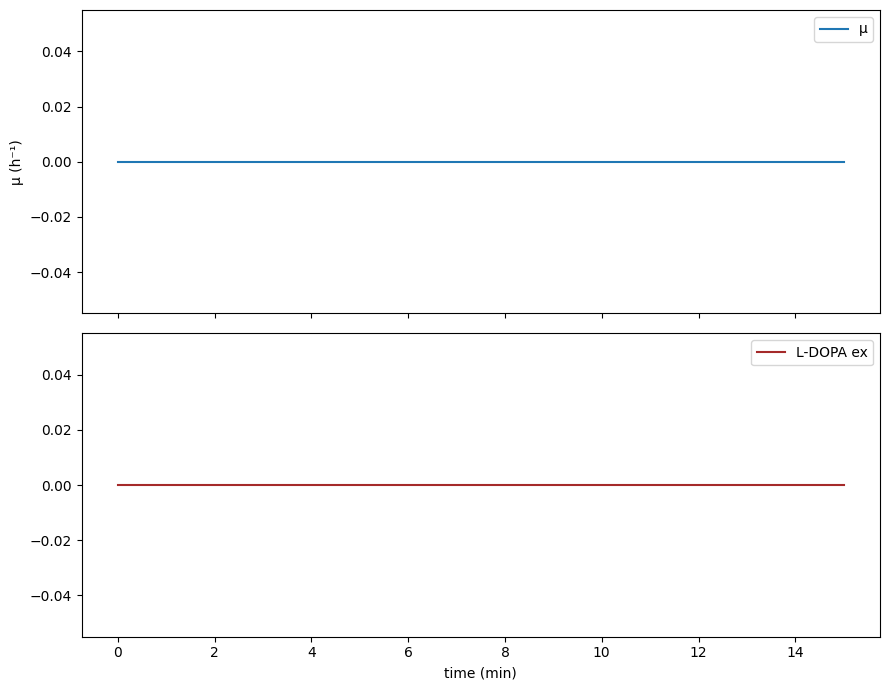

In [108]:
# === Cell 13: Single-cell dynamic FBA (15 min, GLPK) with mechanistic QS & MazE/MazF ===
import numpy as np, math, pandas as pd, logging, warnings
from cobra import Reaction, Metabolite
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
for name in ("ME modelNone","pytfa","cobra","optlang"):
    try: logging.getLogger(name).setLevel(logging.ERROR)
    except Exception: pass

def set_glpk(model):
    try: model.solver="glpk_exact"; return "glpk_exact"
    except Exception: model.solver="glpk"; return "glpk"

# ---- robust EX resolver (uses your model’s EX_*_e ids) ----
def ex_rxn_for(base_candidates):
    """Return first exchange rxn id that exists from an ordered candidate list."""
    ids = {r.id for r in etfl_model.reactions}
    for rid in base_candidates:
        if rid in ids:
            return rid
    return None

EXIDS = dict(
    glc   = ex_rxn_for(["EX_glc__D_e","EX_glc__D","EX_glc_e"]),
    o2    = ex_rxn_for(["EX_o2_e","EX_o2"]),
    nh4   = ex_rxn_for(["EX_nh4_e","EX_nh4"]),
    pi    = ex_rxn_for(["EX_pi_e","EX_pi"]),
    so4   = ex_rxn_for(["EX_so4_e","EX_so4"]),
    cate  = ex_rxn_for(["EX_catechol_e","EX_catechol"]),
    dopa  = ex_rxn_for(["EX_dopa_e","EX_L_DOPA_e","EX_L_DOPA_c"]),
    ahl   = ex_rxn_for(["EX_ahl_e","EX_AHL_e"]),
    co2   = ex_rxn_for(["EX_co2_e","EX_co2"]),
    h2o   = ex_rxn_for(["EX_h2o_e","EX_h2o"])
)

def rxn_if_exists(rid):
    try: return etfl_model.reactions.get_by_id(rid)
    except Exception: return None

# ---- realism: NGAM + ΔGAM_plasmid + basal MazE ----
def enforce_realism(NGAM_ATP=8.39, dGAM_ATP=10.0, mazE_TL_LB=0.005):
    # ATPM
    def mid(x):
        for s in ("_c","_e",""):
            try: return etfl_model.metabolites.get_by_id(x+s)
            except: pass
        return None
    ATP,ADP,PI,H2O,H = map(mid, ("atp","adp","pi","h2o","h"))
    if all([ATP,ADP,PI,H2O,H]) and "ATPM" not in [r.id for r in etfl_model.reactions]:
        r=Reaction("ATPM"); r.lower_bound=0.0; r.upper_bound=1000.0
        r.add_metabolites({ATP:-1.0,H2O:-1.0,ADP:+1.0,PI:+1.0,H:+1.0}); etfl_model.add_reactions([r])
    if "ATPM" in [r.id for r in etfl_model.reactions]:
        etfl_model.reactions.get_by_id("ATPM").lower_bound = NGAM_ATP
    # ΔGAM plasmid inside biomass
    bio = next((r for r in etfl_model.reactions if "biomass" in (r.id+r.name).lower()), None)
    if bio and ATP and ADP and PI and H:
        cur = bio.metabolites.get(ATP, 0.0); target = cur - dGAM_ATP
        if abs(target-cur)>1e-9:
            bio.add_metabolites({ATP:-dGAM_ATP,ADP:+dGAM_ATP,PI:+dGAM_ATP,H:+dGAM_ATP})
        etfl_model.objective = bio.id
    # basal MazE burden
    r=rxn_if_exists("TL_mazE")
    if r: r.lower_bound = mazE_TL_LB

# ---- open gut exchanges ----
def open_env_gut():
    for rid,lb in [(EXIDS["glc"],-10.0),(EXIDS["o2"],-1000.0),(EXIDS["nh4"],-1000.0),
                   (EXIDS["so4"],-1000.0),(EXIDS["pi"],-1000.0),(EXIDS["h2o"],-1000.0),(EXIDS["co2"],0.0)]:
        r = rxn_if_exists(rid); 
        if r: r.lower_bound = lb
    set_temperature(37.0)

# ---- Monod cap ----
def monod(vmax, Ks, S_mM):
    return 0.0 if S_mM<=1e-6 else vmax*(S_mM/(Ks+S_mM))

# ---- single-cell simulation (15 min) ----
def simulate_single_cell_15min(seed=1, catechol_feed=0.0):
    np.random.seed(seed)
    # enforce realism & open gut
    enforce_realism(8.39,10.0,0.005)
    open_env_gut()
    # optionally allow catechol uptake
    if EXIDS["cate"]:
        rxn_if_exists(EXIDS["cate"]).lower_bound = float(catechol_feed)

    # initial external pools (mM)
    S = {"glc":10.0,"o2":1000.0,"nh4":100.0,"pi":50.0,"so4":50.0,"cate":max(0.0,-catechol_feed)}

    # initialize mechanistic states
    qs_state = qs_init_state()
    ta_state = mazef_init_state()

    # time grid
    T_end_min = 15; dt_sec = 30
    dt_h = dt_sec/3600.0; steps = int(T_end_min*60/dt_sec)
    AHL_ext = 0.0   # well-mixed approximation
    X = 0.005       # gDW
    rows=[]

    for k in range(steps+1):
        t_h = k*dt_h

        # mechanistic regulation step (QS & MazE/MazF) -> pushes TX_tpl UB + MazF cleavage LB
        qs_state, ta_state, act, enforced = mech_regulation_step(
            qs_state, ta_state, X_gDW=X, AHL_ext_mM=AHL_ext, t_h=t_h, dt_h=dt_h,
            use_flow=False, flow_rate=0.0
        )

        # Monod set on glc & o2
        for key, (rid, vmax, Ks) in dict(
            glc=(EXIDS["glc"],10.0,0.1),
            o2 =(EXIDS["o2"],1000.0,0.01),
        ).items():
            r = rxn_if_exists(rid)
            if r:
                r.lower_bound = -monod(vmax, Ks, S[key])

        # solve
        set_glpk(etfl_model)
        sol = etfl_model.optimize()
        mu = float(sol.objective_value or 0.0)

        # update AHL_ext from synth/deg/ex (use AHL_SYN and EX_ahl if present)
        ahl_syn = float(sol.fluxes.get("AHL_SYN", 0.0)) if "AHL_SYN" in [r.id for r in etfl_model.reactions] else 0.0
        ahl_ex  = float(sol.fluxes.get(EXIDS["ahl"],0.0)) if EXIDS["ahl"] else 0.0
        AHL_ext = max(0.0, AHL_ext + dt_h*(ahl_syn - 0.2*AHL_ext - max(0.0,ahl_ex)))

        # update external GLU & O2 pools (mM): ∆S = v*X*dt / V; here V=1 mL = 1e-3 L
        V_L = 1e-3
        for key,rid in (("glc",EXIDS["glc"]),("o2",EXIDS["o2"])):
            r = rxn_if_exists(rid)
            if r:
                v = float(sol.fluxes.get(r.id, 0.0))
                if v<0:
                    S[key] = max(0.0, S[key] + (v*X*dt_h)/V_L)

        # read L-DOPA export
        dopa_ex = 0.0
        if EXIDS["dopa"]:
            dopa_ex = float(sol.fluxes.get(EXIDS["dopa"],0.0))

        rows.append({"t_min":t_h*60, "mu":mu, "AHL_ext":AHL_ext, "glc_mM":S["glc"], "o2_mM":S["o2"], "ldopa_ex":dopa_ex})

    df = pd.DataFrame(rows)
    display(df.head())
    out = RES/"single_cell_15min_mech.csv"
    df.to_csv(out, index=False); print("Saved:", out)
    # plot
    fig,axs=plt.subplots(2,1,figsize=(9,7),sharex=True)
    axs[0].plot(df.t_min, df.mu, label="μ"); axs[0].set_ylabel("μ (h⁻¹)"); axs[0].legend()
    axs[1].plot(df.t_min, df.ldopa_ex, c="brown", label="L-DOPA ex"); axs[1].legend(); axs[1].set_xlabel("time (min)")
    plt.tight_layout(); plt.savefig(RES/"single_cell_15min_mech.png", dpi=160); plt.show()

simulate_single_cell_15min(seed=7, catechol_feed=0.0)  # set catechol_feed=-5.0 for feeding


Temperature unchanged (T=37.0°C).


Empty DataFrame
Columns: []
Index: []

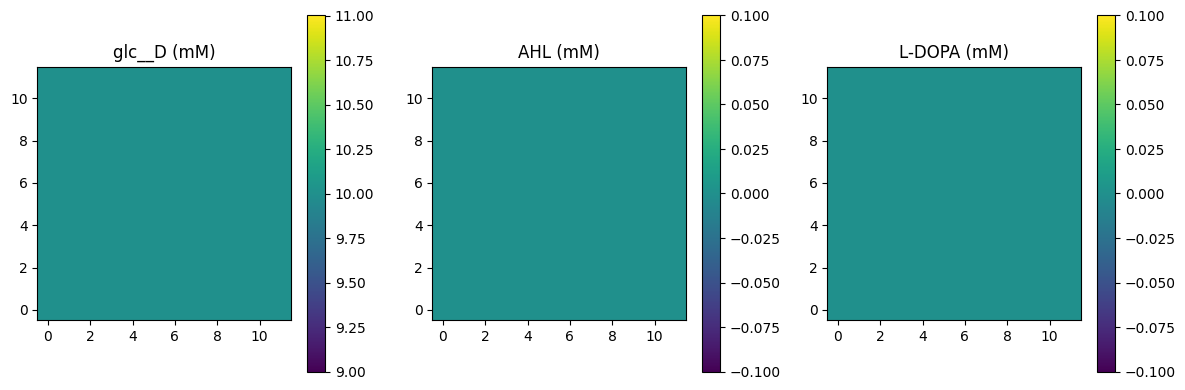

In [109]:
# === Cell 14: Spatial 2-D ABM + gut flow + mechanistic QS & MazE/MazF (GLPK, fast) ===
import numpy as np, pandas as pd, logging, warnings, math
from cobra import Reaction, Metabolite
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
for name in ("ME modelNone","pytfa","cobra","optlang"):
    try: logging.getLogger(name).setLevel(logging.ERROR)
    except Exception: pass

def set_glpk(model):
    try: model.solver="glpk_exact"; return "glpk_exact"
    except Exception: model.solver="glpk"; return "glpk"

# re-use EXIDS/rxn_if_exists/enforce_realism/open_env_gut from Cell 13
# (they’re in the same kernel; if not, copy them here)

# grid/time small enough to finish ≲10 min
grid=(12,12); dx=1.0
dt_h = 3.0/60.0     # 3 min
steps = 20          # 1 h total
N_agents=9
V_voxel_L = 1e-3    # 1 mL per cell

# fields mM
species=["glc","o2","catechol","AHL","DOPA"]
sidx={sp:i for i,sp in enumerate(species)}
F=np.zeros((len(species),grid[0],grid[1]),dtype=float)
F[sidx["glc"]]=10.0; F[sidx["o2"]]=1000.0; F[sidx["catechol"]]=0.0
D={"glc":0.5, "o2":1.0, "catechol":0.3, "AHL":0.2, "DOPA":0.4}

# gut flow
USE_FLOW_ENV=True; flow_rate=0.05
S_in={"glc":10.0,"o2":1000.0,"catechol":0.0}

# agents
rng=np.random.default_rng(17)
coords=list(zip(rng.integers(0,grid[0],N_agents), rng.integers(0,grid[1],N_agents)))
agents=[]
for cid,(x,y) in enumerate(coords):
    agents.append({"id":cid,"x":int(x),"y":int(y),
                   "X":0.005,  # gDW
                   "qs":qs_init_state(), "ta":mazef_init_state(),
                   "alive":True})

# enforce realism & open env once
enforce_realism(8.39,10.0,0.005); open_env_gut()

def diffuse(F,D,dt):
    G=F.copy()
    for sp,dif in D.items():
        k=sidx[sp]; a=F[k]; lap=np.zeros_like(a)
        lap[1:-1,1:-1]=(a[:-2,1:-1]+a[2:,1:-1]+a[1:-1,:-2]+a[1:-1,2:]-4*a[1:-1,1:-1])
        G[k]+=dif*lap*dt/(dx**2); G[k]=np.clip(G[k],0,None)
    return G

trace=[]
for it in range(steps+1):
    t=it*dt_h
    # diffuse
    F=diffuse(F,D,dt_h)
    # flow
    if USE_FLOW_ENV:
        for sp in ("glc","o2","catechol"):
            F[sidx[sp]] += flow_rate*(S_in[sp]-F[sidx[sp]])*dt_h
            F[sidx[sp]] = np.clip(F[sidx[sp]],0.0,None)

    for a in agents:
        if not a["alive"]: continue
        x,y=a["x"],a["y"]; X=a["X"]

        # mechanistic step (uses extracellular AHL at voxel)
        AHL_ext=float(F[sidx["AHL"],x,y])
        a["qs"], a["ta"], act, enforced = mech_regulation_step(
            a["qs"], a["ta"], X_gDW=X, AHL_ext_mM=AHL_ext, t_h=t, dt_h=dt_h,
            use_flow=USE_FLOW_ENV, flow_rate=flow_rate
        )

        # Monod caps from local pools
        caps = {
            EXIDS["glc"]:     (10.0,0.1, float(F[sidx["glc"],x,y])),
            EXIDS["o2"]:      (1000.0,0.01,float(F[sidx["o2"],x,y])),
            EXIDS["cate"]:    (5.0,0.1,  float(F[sidx["catechol"],x,y])),
            EXIDS["nh4"]:     (1000.0,0.01,100.0),
            EXIDS["pi"]:      (1000.0,0.01,50.0),
            EXIDS["so4"]:     (1000.0,0.01,50.0)
        }
        pushed=[]
        for rid,(vmax,Ks,S) in caps.items():
            if not rid: continue
            r=rxn_if_exists(rid); 
            if not r: continue
            before=(r.lower_bound,r.upper_bound)
            vmax_eff = 0.0 if S<=1e-6 else vmax*(S/(Ks+S))
            r.lower_bound = -vmax_eff; pushed.append((r,before))

        # solve LP
        set_glpk(etfl_model)
        sol=etfl_model.optimize()
        if sol.status!="optimal":
            for r,b in pushed: r.lower_bound,r.upper_bound=b
            a["alive"]=False; 
            continue

        mu=float(sol.objective_value or 0.0)

        # AHL synthesis & L-DOPA export
        ahl_syn=float(sol.fluxes.get("AHL_SYN",0.0)) if "AHL_SYN" in [r.id for r in etfl_model.reactions] else 0.0
        dopa_ex=0.0
        if EXIDS["dopa"]: dopa_ex=float(sol.fluxes.get(EXIDS["dopa"],0.0))

        # update voxel pools (mM) using v*X*dt/V
        for rid,key in ((EXIDS["glc"],"glc"), (EXIDS["o2"],"o2"), (EXIDS["cate"],"catechol")):
            r=rxn_if_exists(rid)
            if not r: continue
            v=float(sol.fluxes.get(r.id,0.0))
            if v<0:
                F[sidx[key],x,y]=max(0.0, F[sidx[key],x,y] + (v*X*dt_h)/V_voxel_L)
        F[sidx["AHL"], x,y]  += max(0.0,ahl_syn)*dt_h/V_voxel_L
        F[sidx["DOPA"],x,y] += max(0.0,dopa_ex)*dt_h/V_voxel_L

        # restore bounds
        for r,b in pushed: r.lower_bound,r.upper_bound=b

        # biomass update (quasi-exponential)
        a["X"]=max(1e-9, X*(1.0 + mu*dt_h))
        trace.append({"t_min":t*60,"cell":a["id"],"x":x,"y":y,"mu":mu,"X":a["X"],"DOPA_ex":dopa_ex})

# save + fields snapshot
abm_df=pd.DataFrame(trace); display(abm_df.head())
abm_df.to_csv(RES/"abm_spatial_gut_mech.csv", index=False)

fig,axes=plt.subplots(1,3,figsize=(12,4))
for ax, sp, title in zip(axes,["glc","AHL","DOPA"],["glc__D (mM)","AHL (mM)","L-DOPA (mM)"]):
    im=ax.imshow(F[sidx[sp]],origin='lower',cmap='viridis'); ax.set_title(title); plt.colorbar(im,ax=ax)
plt.tight_layout(); plt.savefig(RES/"abm_fields_gut_mech.png",dpi=160); plt.show()


In [110]:
[r.id for r in etfl_model.reactions if r.id.startswith("EX_")][:100]


['EX_12dgr160_e',
 'EX_12dgr180_e',
 'EX_13dampp_e',
 'EX_15dap_e',
 'EX_1ag160_e',
 'EX_1ag180_e',
 'EX_1ag181d9_e',
 'EX_1ag182d9d12_e',
 'EX_25dkglcn_e',
 'EX_26dap__M_e',
 'EX_AEP_e',
 'EX_2ddglcn_e',
 'EX_2dhglcn_e',
 'EX_2m35mdntha_e',
 'EX_34dhbz_e',
 'EX_34dhcinm_e',
 'EX_34dhphe_e',
 'EX_35dnta_e',
 'EX_3h4atb_e',
 'EX_3mb_e',
 'EX_btd_RR_e',
 'EX_btn_e',
 'EX_butso3_e',
 'EX_bz_e',
 'EX_ca2_e',
 'EX_carn_e',
 'EX_catechol_e',
 'EX_cbi_e',
 'EX_cbl1_e',
 'EX_cd2_e',
 'EX_cell4_e',
 'EX_cgly_e',
 'EX_chol_e',
 'EX_chols_e',
 'EX_chor_e',
 'EX_cinnm_e',
 'EX_cit_e',
 'EX_cl_e',
 'EX_cm_e',
 'EX_cmcbtt_e',
 'EX_co2_e',
 'EX_co_e',
 'EX_cobalt2_e',
 'EX_confrl_e',
 'EX_creat_e',
 'EX_crn_e',
 'EX_cro2_e',
 'EX_cro4_e',
 'EX_crtn_e',
 'EX_csn_e',
 'EX_cu2_e',
 'EX_cu_e',
 'EX_cyan_e',
 'EX_cys__D_e',
 'EX_cys__L_e',
 'EX_dag181d9_e',
 'EX_dag182d9d12_e',
 'EX_dca_e',
 'EX_ddca_e',
 'EX_dgudbutn_e',
 'EX_dmanur_e',
 'EX_dmgly_e',
 'EX_dmso2_e',
 'EX_dopa_e',
 'EX_ecto__L_e',
 'EX_en

Loaded FBA scenario table.


env                   scenario   status      solver  growth  \
0  in_vivo_gut                  WT no TPL  optimal  glpk_exact     0.0   
1  in_vivo_gut     WT + TPL (no catechol)  optimal  glpk_exact     0.0   
2  in_vivo_gut    TPL + KOs (no catechol)  optimal  glpk_exact     0.0   
3  in_vivo_gut   WT + TPL (catechol feed)  optimal  glpk_exact     0.0   
4  in_vivo_gut  TPL + KOs (catechol feed)  optimal  glpk_exact     0.0   

   ldopa_ex  ATP_total  GTP_total  
0       0.0     7.6442        NaN  
1       0.0     7.6442        NaN  
2       0.0     7.6442        NaN  
3       0.0     7.6442        NaN  
4       0.0     7.6442        NaN

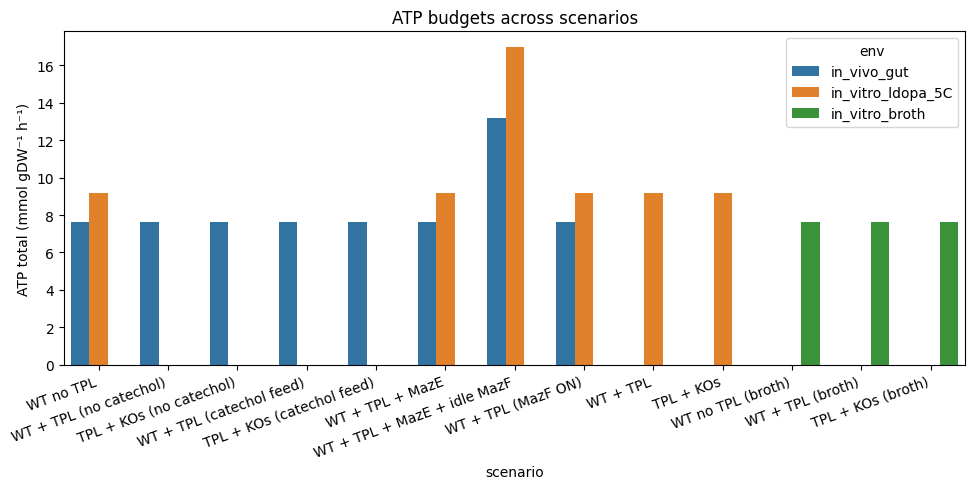

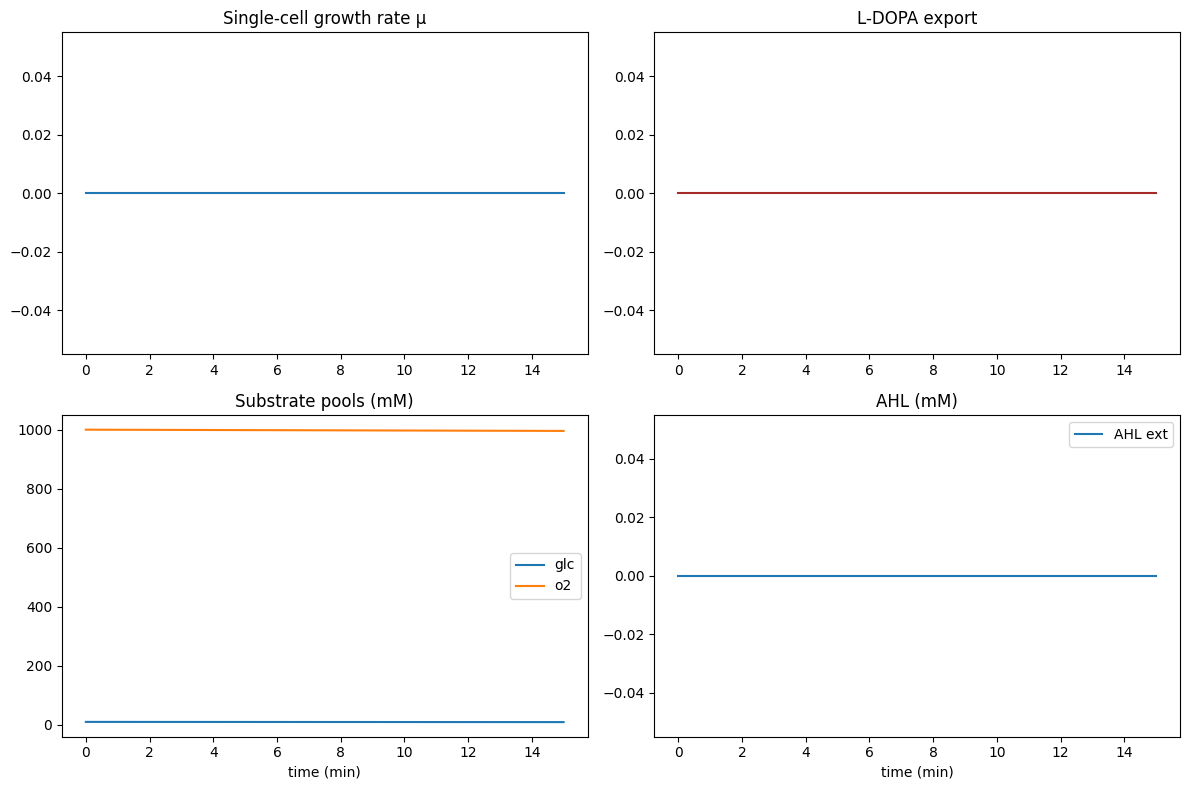

[skip] could not read /workspace/results/abm_spatial_gut_mech.csv: No columns to parse from file
[info] ABM CSV not found: /workspace/results/abm_spatial_gut_mech.csv


In [111]:
# === Cell 16: Robust summary plots for FBA, single-cell, and ABM outputs ===
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

def safe_read_csv(path):
    """Return DataFrame or None if file missing/empty/invalid."""
    p = Path(path)
    if not p.exists():
        print(f"[skip] not found: {p}")
        return None
    try:
        df = pd.read_csv(p)
        if df.empty or (len(df.columns)==0):
            print(f"[skip] empty file: {p}")
            return None
        return df
    except Exception as e:
        print(f"[skip] could not read {p}: {e}")
        return None

# ---------- 1) FBA scenarios ----------
candidates = [
    RES/"env_scenarios_glpk_with_MazF.csv",
    RES/"fba_realistic_envs.csv",
    RES/"fba_scenarios_summary.csv"
]
scen_df = next((safe_read_csv(p) for p in candidates if Path(p).exists()), None)

if scen_df is not None:
    print("Loaded FBA scenario table.")
    # minimal subset for readability
    cols_pref = [c for c in ("env","scenario","label","status","solver","growth","ldopa_ex","ATP_total","GTP_total") if c in scen_df.columns]
    display(scen_df[cols_pref].round(4).head())

    # ATP totals bar plot if available
    if "ATP_total" in scen_df.columns:
        plt.figure(figsize=(10,5))
        xcol = "scenario" if "scenario" in scen_df.columns else ("label" if "label" in scen_df.columns else None)
        if xcol is not None:
            sns.barplot(data=scen_df, x=xcol, y="ATP_total", hue="env" if "env" in scen_df.columns else None)
            plt.xticks(rotation=20, ha='right')
            plt.ylabel("ATP total (mmol gDW⁻¹ h⁻¹)")
            plt.title("ATP budgets across scenarios")
            plt.tight_layout(); plt.savefig(RES/"ATP_budgets_scenarios.png", dpi=150); plt.show()

# ---------- 2) Single-cell dynamic (from Cell 13) ----------
single_path = RES/"single_cell_15min_mech.csv"
single_df = safe_read_csv(single_path)

if single_df is not None:
    # harmonize column names
    tcol = "t_min" if "t_min" in single_df.columns else ("time_h" if "time_h" in single_df.columns else None)
    mucol = "mu" if "mu" in single_df.columns else ("growth_rate" if "growth_rate" in single_df.columns else None)
    Lcol  = "ldopa_ex" if "ldopa_ex" in single_df.columns else ("ldopa_ex_flux" if "ldopa_ex_flux" in single_df.columns else None)
    gcol  = "glc_mM" if "glc_mM" in single_df.columns else None
    ocol  = "o2_mM"  if "o2_mM"  in single_df.columns else None
    acol  = "AHL_ext" if "AHL_ext" in single_df.columns else ("AHL_conc" if "AHL_conc" in single_df.columns else None)

    if tcol and mucol and Lcol:
        fig,axs=plt.subplots(2,2,figsize=(12,8))
        axs[0,0].plot(single_df[tcol], single_df[mucol]); axs[0,0].set_title("Single-cell growth rate μ")
        axs[0,1].plot(single_df[tcol], single_df[Lcol], c='brown'); axs[0,1].set_title("L-DOPA export")
        if gcol and ocol:
            axs[1,0].plot(single_df[tcol], single_df[gcol], label="glc"); 
            axs[1,0].plot(single_df[tcol], single_df[ocol], label="o2"); 
            axs[1,0].legend(); axs[1,0].set_title("Substrate pools (mM)")
        if acol:
            axs[1,1].plot(single_df[tcol], single_df[acol], label="AHL ext"); axs[1,1].legend(); axs[1,1].set_title("AHL (mM)")
        for ax in axs[-1,:]: ax.set_xlabel("time (min)" if "min" in tcol else "time (h)")
        plt.tight_layout(); plt.savefig(RES/"single_cell_panels_mech.png", dpi=150); plt.show()
    else:
        print("[skip] single-cell file lacks expected columns.")
else:
    print("[info] single-cell CSV not found:", single_path)

# ---------- 3) ABM spatial (from Cell 14) ----------
abm_path = RES/"abm_spatial_gut_mech.csv"
abm_df = safe_read_csv(abm_path)

if abm_df is not None:
    # look for time / growth columns
    tcol = "t_min" if "t_min" in abm_df.columns else ("time" if "time" in abm_df.columns else None)
    mucol = "mu" if "mu" in abm_df.columns else None

    if tcol and mucol:
        g = abm_df.groupby(tcol)[mucol].mean().reset_index()
        plt.figure(figsize=(7,4)); plt.plot(g[tcol], g[mucol])
        plt.xlabel("time (min)" if "min" in tcol else "time (h)")
        plt.ylabel("⟨μ⟩ (h⁻¹)")
        plt.title("ABM: mean growth rate over time (gut flow)")
        plt.tight_layout(); plt.savefig(RES/"abm_mu_time_gut.png", dpi=150); plt.show()
    else:
        print("[skip] ABM file lacks expected columns.")
else:
    print("[info] ABM CSV not found:", abm_path)
